In [1]:
import time
import bs4
import random
import requests
import pandas as pd
import numpy as np

In [2]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException
import time
import pandas as pd

# Step 1: Load the webpage
url = "https://rafffle.famousfoxes.com/"
driver = webdriver.Chrome()

# Initialize an empty list to collect all the data
listings_data = []

try:
    # Open the webpage
    driver.get(url)
    print("Opened the webpage.")
    
    # Scroll to find the "Past Raffles" button and click it
    while True:
        try:
            past_raffles_button = WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable((By.XPATH, "//button[text()='Past Raffles']"))
            )
            past_raffles_button.click()
            time.sleep(2)  # Wait for the page to load
            print("Clicked on 'Past Raffles' button.")
            break
        except Exception as e:
            driver.execute_script("window.scrollBy(0, 300);")
            time.sleep(1)
    
    # Step 3: Scroll down to load more listings until no new listings are loaded
    while True:
        listings = driver.find_elements(By.XPATH, '//*[@id="root"]/main/div[4]/div[2]/div/div[3]/div')
        initial_count = len(listings)
        driver.find_element(By.TAG_NAME, 'body').send_keys(Keys.END)
        time.sleep(2)  # Adjust time if necessary to allow more listings to load
        listings = driver.find_elements(By.XPATH, '//*[@id="root"]/main/div[4]/div[2]/div/div[3]/div')
        if len(listings) == initial_count:
            print(f"Loaded all available listings: {len(listings)} listings.")
            break

    # Step 4: Extract the required data from each listing and store it in the list
    for i, listing in enumerate(listings):
        print(f"Processing listing #{i+1}")
        try:
            brand = listing.find_element(By.XPATH, './/div[2]/div[1]/a').text
            title = listing.find_element(By.XPATH, './/div[2]/h2').text
            seller = listing.find_element(By.XPATH, './/div[2]/div[2]/a').text
            
            # Conditional checks for Tickets Remaining
            if len(listing.find_elements(By.XPATH, './/div[2]/div[3]/div[1]/div')) > 0:
                tickets_remaining = listing.find_element(By.XPATH, './/div[2]/div[3]/div[1]/div').text
            elif len(listing.find_elements(By.XPATH, './/div[2]/div[2]/div[3]/div[1]/div')) > 0:
                tickets_remaining = listing.find_element(By.XPATH, './/div[2]/div[2]/div[3]/div[1]/div').text
            else:
                print(f"Error: Tickets Remaining element not found for listing #{i+1}")
                raise NoSuchElementException("Tickets Remaining element not found.")
            
            tier = listing.find_element(By.XPATH, './/div[2]/div[2]/div/div[2]').text
            price_ticket = listing.find_element(By.XPATH, './/div[2]/div[3]/div[2]/div').text
            
            # Conditional checks for Time
            if len(listing.find_elements(By.XPATH, './/div[2]/div[4]/a/span')) > 0:
                time_ = listing.find_element(By.XPATH, './/div[2]/div[4]/a/span').text
            elif len(listing.find_elements(By.XPATH, './/div[2]/div[2]/div[5]/a/span')) > 0:
                time_ = listing.find_element(By.XPATH, './/div[2]/div[2]/div[5]/a/span').text
            elif len(listing.find_elements(By.XPATH, './/div[2]/div[2]/div[4]/a/span/span')) > 0:
                time_ = listing.find_element(By.XPATH, './/div[2]/div[2]/div[4]/a/span/span').text
            elif len(listing.find_elements(By.XPATH, './/div[2]/div[2]/div[5]/a/span')) > 0:
                time_ = listing.find_element(By.XPATH, './/div[2]/div[2]/div[5]/a/span').text
            else:
                # Attempt to extract the "Ended" statement using CSS selector
                ended_elements = listing.find_elements(By.CSS_SELECTOR, "a.from-gray-300.to-gray-300.border-gray-300.text-gray-600.dark\\:text-gray-400.block.flex-1.text-center.py-3.mt-2.bg-gradient-to-t.opacity-90.hover\\:opacity-100.text-white.text-xl.rounded-2xl.border.dark\\:to-transparent.dark\\:from-transparent.dark\\:border-2.transition-all span.text-sm.block")
                if ended_elements:
                    time_ = ended_elements[0].text
                else:
                    print(f"Error: Time element not found for listing #{i+1}")
                    raise NoSuchElementException("Time element not found.")
            
            # Conditional checks for Link
            if len(listing.find_elements(By.XPATH, './/div[2]/div[4]/a')) > 0:
                link = listing.find_element(By.XPATH, './/div[2]/div[4]/a').get_attribute('href')
            elif len(listing.find_elements(By.XPATH, './/div[2]/div[2]/div[5]/a')) > 0:
                link = listing.find_element(By.XPATH, './/div[2]/div[2]/div[5]/a').get_attribute('href')
            elif len(listing.find_elements(By.XPATH, './/div[2]/div[2]/div[4]/a')) > 0:
                link = listing.find_element(By.XPATH, './/div[2]/div[2]/div[4]/a').get_attribute('href')
            else:
                # Additional check using CSS class
                link_elements = listing.find_elements(By.CSS_SELECTOR, "a.from-gray-300.to-gray-300.border-gray-300.text-gray-600.dark\\:text-gray-400.block.flex-1.text-center.py-3.mt-2.bg-gradient-to-t.opacity-90.hover\\:opacity-100.text-white.text-xl.rounded-2xl.border.dark\\:to-transparent.dark\\:from-transparent.dark\\:border-2.transition-all")
                if link_elements:
                    link = link_elements[0].get_attribute('href')
                else:
                    print(f"Error: Link element not found for listing #{i+1}")
                    raise NoSuchElementException("Link element not found.")

            # Append the data to the listings_data list
            listings_data.append({
                "Brand": brand,
                "Title": title,
                "Seller": seller,
                "Tickets Remaining": tickets_remaining,
                "Tier": tier,
                "Price/Ticket": price_ticket,
                "Time": time_,
                "Link": link
            })
        
        except Exception as e:
            print(f"Error processing listing #{i+1}: {e}")

finally:
    # Close the browser
    driver.quit()
    print("Closed the browser.")

# Convert the listings_data list to a pandas DataFrame
df = pd.DataFrame(listings_data)
df.head()

# Save the DataFrame to a CSV file
df.to_csv("raffle_listings-14June.csv", index=False)

Opened the webpage.
Clicked on 'Past Raffles' button.
Loaded all available listings: 120 listings.
Processing listing #1
Processing listing #2
Processing listing #3
Processing listing #4
Processing listing #5
Processing listing #6
Processing listing #7
Processing listing #8
Processing listing #9
Processing listing #10
Processing listing #11
Processing listing #12
Processing listing #13
Processing listing #14
Processing listing #15
Processing listing #16
Processing listing #17
Processing listing #18
Processing listing #19
Processing listing #20
Processing listing #21
Processing listing #22
Processing listing #23
Processing listing #24
Processing listing #25
Processing listing #26
Processing listing #27
Processing listing #28
Processing listing #29
Processing listing #30
Processing listing #31
Processing listing #32
Processing listing #33
Processing listing #34
Processing listing #35
Processing listing #36
Processing listing #37
Processing listing #38
Processing listing #39
Processing li

In [6]:
df.head()

,Brand,Title,Seller,Tickets Remaining,Tier,Price/Ticket,Time,Link
0,Famous Fox Federation,Fox #2898,@JZJoker0,SOLD OUT,T4,0.111 SOL,Ended 28 mins 33 s ago.,https://rafffle.famousfoxes.com/raffle/EoidpoY...
1,Verified Token,80 WIF,@jackondis123,SOLD OUT,T4,0.0316 SOL,Ended 34 mins 27 s ago.,https://rafffle.famousfoxes.com/raffle/9hhteY8...
2,Frogana,Frogana #2939,@Roslin_ez,SOLD OUT,T3,0.0166 SOL,Ended 35 mins 26 s ago.,https://rafffle.famousfoxes.com/raffle/4afDhGe...
3,Sharx By Sharky.Fi,sharx #9605,@Samoyed_Kids,SOLD OUT,T3,0.0376 SOL,Ended 1 hrs 12 mins ago.,https://rafffle.famousfoxes.com/raffle/6ft4M82...
4,Verified Token,80 WIF,@jackondis123,SOLD OUT,T4,0.0316 SOL,Ended 1 hrs 41 mins ago.,https://rafffle.famousfoxes.com/raffle/wBoPrXQ...


In [9]:
import pandas as pd
import time
import re
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.common.exceptions import NoSuchElementException

# Initialize Selenium WebDriver
options = Options()
options.headless = True
driver = webdriver.Chrome(options=options)


# Create new columns in the DataFrame
df['Floor Price'] = ''
df['Total Ticket Value'] = ''
df['Winner'] = ''
df['Winner Tickets'] = ''
df['Ticket Frequency'] = ''

# Function to clean and extract the first 4 letters of a username
def clean_username(username):
    # Remove symbols and get the first 4 letters
    return re.sub(r'[^A-Za-z0-9]', '', username)[:4]

# Function to extract data from each link
def extract_data(link):
    driver.get(link)
    
    try:
        time.sleep(1)
        # Click on the Participants button using the updated XPath
        participants_button = driver.find_element(By.XPATH, "//*[@id='root']/main/div[4]/div/div[2]/div[1]/div[4]/div/button[2]")
        participants_button.click()
        
        # Extract the required data using XPath
        floor_price = driver.find_element(By.XPATH, "//*[@id='root']/main/div[4]/div/div[2]/div[1]/div[1]/div[1]/div[3]/div[1]/span/strong").text
        total_ticket_value = driver.find_element(By.XPATH, "//*[@id='root']/main/div[4]/div/div[2]/div[1]/div[1]/div[1]/div[3]/div[2]/span/strong").text
        winner = driver.find_element(By.XPATH, "//*[@id='root']/main/div[4]/div/div[1]/div[2]/div[2]").text
        cleaned_winner = clean_username(winner)

        # Extract the participant list table
        participants_table = driver.find_element(By.XPATH, "//*[@id='root']/main/div[4]/div/div[2]/div[1]/div[5]/div/div/div[1]/div/div/table/tbody")
        rows = participants_table.find_elements(By.TAG_NAME, "tr")
        
        winner_tickets = None
        tickets_bought = []
        frequency = []
        
        for row in rows:
            username_element = row.find_element(By.XPATH, "./td[1]/div/a[1]")
            tickets_bought_element = row.find_element(By.XPATH, "./td[2]")
            cleaned_username = clean_username(username_element.text)
            
            if cleaned_username == cleaned_winner:
                winner_tickets = tickets_bought_element.text
            
            tickets_bought.append(int(tickets_bought_element.text.strip()))
            frequency.append(1)  # Assuming each row represents one transaction
        
        if winner_tickets is None:
            raise NoSuchElementException(f"Winner {winner} not found in participant list.")
        
        ticket_frequency = {
            'Tickets bought': tickets_bought,
            'Frequency': frequency
        }
        
        return {
            'Floor Price': floor_price,
            'Total Ticket Value': total_ticket_value,
            'Winner': winner,
            'Winner Tickets': winner_tickets,
            'Ticket Frequency': ticket_frequency
        }
    except NoSuchElementException as e:
        print(f"Error while processing {link}: {e}")
        return {
            'Floor Price': None,
            'Total Ticket Value': None,
            'Winner': None,
            'Winner Tickets': None,
            'Ticket Frequency': None
        }

# Iterate over each link and extract data
for index, row in df.iterrows():
    data = extract_data(row['Link'])
    df.at[index, 'Floor Price'] = data['Floor Price']
    df.at[index, 'Total Ticket Value'] = data['Total Ticket Value']
    df.at[index, 'Winner'] = data['Winner']
    df.at[index, 'Winner Tickets'] = data['Winner Tickets']
    df.at[index, 'Ticket Frequency'] = str(data['Ticket Frequency'])

# Save the updated DataFrame to a new CSV file
df.to_csv('updated_data-Week3.csv', index=False)

# Display the first few rows of the updated DataFrame
df.head()

# Close the WebDriver
driver.quit()

Error while processing https://rafffle.famousfoxes.com/raffle/3GidM4cBVBALPyQac4bYB7bipaYK1jhwb6DVisX4pF5E: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//*[@id='root']/main/div[4]/div/div[1]/div[2]/div[2]"}
  (Session info: chrome=126.0.6478.61); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6BD053E52+31618]
	(No symbol) [0x00007FF6BCFCB0B9]
	(No symbol) [0x00007FF6BCE8888A]
	(No symbol) [0x00007FF6BCED8524]
	(No symbol) [0x00007FF6BCED862C]
	(No symbol) [0x00007FF6BCF1F787]
	(No symbol) [0x00007FF6BCEFD14F]
	(No symbol) [0x00007FF6BCF1CA80]
	(No symbol) [0x00007FF6BCEFCEB3]
	(No symbol) [0x00007FF6BCECA46B]
	(No symbol) [0x00007FF6BCECB001]
	GetHandleVerifier [0x00007FF6BD35A02D+3202397]
	GetHandleVerifier [0x00007FF6BD3A6A4D+3516285]
	GetHandleVerifier [0x00007FF6BD39C4C0+3473904]
	GetHandleVerifier [0x00007F

Error while processing https://rafffle.famousfoxes.com/raffle/6FfnwMG7kduFfpQNmAou6ZWWgr1vz7eGSs4ftQBUCqay: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//*[@id='root']/main/div[4]/div/div[1]/div[2]/div[2]"}
  (Session info: chrome=126.0.6478.61); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6BD053E52+31618]
	(No symbol) [0x00007FF6BCFCB0B9]
	(No symbol) [0x00007FF6BCE8888A]
	(No symbol) [0x00007FF6BCED8524]
	(No symbol) [0x00007FF6BCED862C]
	(No symbol) [0x00007FF6BCF1F787]
	(No symbol) [0x00007FF6BCEFD14F]
	(No symbol) [0x00007FF6BCF1CA80]
	(No symbol) [0x00007FF6BCEFCEB3]
	(No symbol) [0x00007FF6BCECA46B]
	(No symbol) [0x00007FF6BCECB001]
	GetHandleVerifier [0x00007FF6BD35A02D+3202397]
	GetHandleVerifier [0x00007FF6BD3A6A4D+3516285]
	GetHandleVerifier [0x00007FF6BD39C4C0+3473904]
	GetHandleVerifier [0x00007F

Error while processing https://rafffle.famousfoxes.com/raffle/LTTWo6GgjjXPK4Jq4eUG1UGCbcWjddmbytNPmRa7mqN: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//*[@id='root']/main/div[4]/div/div[1]/div[2]/div[2]"}
  (Session info: chrome=126.0.6478.61); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6BD053E52+31618]
	(No symbol) [0x00007FF6BCFCB0B9]
	(No symbol) [0x00007FF6BCE8888A]
	(No symbol) [0x00007FF6BCED8524]
	(No symbol) [0x00007FF6BCED862C]
	(No symbol) [0x00007FF6BCF1F787]
	(No symbol) [0x00007FF6BCEFD14F]
	(No symbol) [0x00007FF6BCF1CA80]
	(No symbol) [0x00007FF6BCEFCEB3]
	(No symbol) [0x00007FF6BCECA46B]
	(No symbol) [0x00007FF6BCECB001]
	GetHandleVerifier [0x00007FF6BD35A02D+3202397]
	GetHandleVerifier [0x00007FF6BD3A6A4D+3516285]
	GetHandleVerifier [0x00007FF6BD39C4C0+3473904]
	GetHandleVerifier [0x00007FF

Error while processing https://rafffle.famousfoxes.com/raffle/77M7pTTSKHLNY7eubsuFw1dhjAYcp1NLXCAfGWGvqrb7: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//*[@id='root']/main/div[4]/div/div[2]/div[1]/div[4]/div/button[2]"}
  (Session info: chrome=126.0.6478.61); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6BD053E52+31618]
	(No symbol) [0x00007FF6BCFCB0B9]
	(No symbol) [0x00007FF6BCE8888A]
	(No symbol) [0x00007FF6BCED8524]
	(No symbol) [0x00007FF6BCED862C]
	(No symbol) [0x00007FF6BCF1F787]
	(No symbol) [0x00007FF6BCEFD14F]
	(No symbol) [0x00007FF6BCF1CA80]
	(No symbol) [0x00007FF6BCEFCEB3]
	(No symbol) [0x00007FF6BCECA46B]
	(No symbol) [0x00007FF6BCECB001]
	GetHandleVerifier [0x00007FF6BD35A02D+3202397]
	GetHandleVerifier [0x00007FF6BD3A6A4D+3516285]
	GetHandleVerifier [0x00007FF6BD39C4C0+3473904]
	GetHandleVeri

Error while processing https://rafffle.famousfoxes.com/raffle/BsgVb7uUG7jHe2zBRsr9iztheECyG5ZbrGogqhEJyuy4: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//*[@id='root']/main/div[4]/div/div[1]/div[2]/div[2]"}
  (Session info: chrome=126.0.6478.61); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6BD053E52+31618]
	(No symbol) [0x00007FF6BCFCB0B9]
	(No symbol) [0x00007FF6BCE8888A]
	(No symbol) [0x00007FF6BCED8524]
	(No symbol) [0x00007FF6BCED862C]
	(No symbol) [0x00007FF6BCF1F787]
	(No symbol) [0x00007FF6BCEFD14F]
	(No symbol) [0x00007FF6BCF1CA80]
	(No symbol) [0x00007FF6BCEFCEB3]
	(No symbol) [0x00007FF6BCECA46B]
	(No symbol) [0x00007FF6BCECB001]
	GetHandleVerifier [0x00007FF6BD35A02D+3202397]
	GetHandleVerifier [0x00007FF6BD3A6A4D+3516285]
	GetHandleVerifier [0x00007FF6BD39C4C0+3473904]
	GetHandleVerifier [0x00007F

Error while processing https://rafffle.famousfoxes.com/raffle/6D4KXW4PNR2RLZNKFkAYYMRVQZPUnZXfs8uJ5VpG4Y34: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//*[@id='root']/main/div[4]/div/div[1]/div[2]/div[2]"}
  (Session info: chrome=126.0.6478.61); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6BD053E52+31618]
	(No symbol) [0x00007FF6BCFCB0B9]
	(No symbol) [0x00007FF6BCE8888A]
	(No symbol) [0x00007FF6BCED8524]
	(No symbol) [0x00007FF6BCED862C]
	(No symbol) [0x00007FF6BCF1F787]
	(No symbol) [0x00007FF6BCEFD14F]
	(No symbol) [0x00007FF6BCF1CA80]
	(No symbol) [0x00007FF6BCEFCEB3]
	(No symbol) [0x00007FF6BCECA46B]
	(No symbol) [0x00007FF6BCECB001]
	GetHandleVerifier [0x00007FF6BD35A02D+3202397]
	GetHandleVerifier [0x00007FF6BD3A6A4D+3516285]
	GetHandleVerifier [0x00007FF6BD39C4C0+3473904]
	GetHandleVerifier [0x00007F

Error while processing https://rafffle.famousfoxes.com/raffle/5tkuFjaHyDzwCTm4XGghCVHFUeopAkEK5YfDEKPfphgy: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//*[@id='root']/main/div[4]/div/div[1]/div[2]/div[2]"}
  (Session info: chrome=126.0.6478.61); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6BD053E52+31618]
	(No symbol) [0x00007FF6BCFCB0B9]
	(No symbol) [0x00007FF6BCE8888A]
	(No symbol) [0x00007FF6BCED8524]
	(No symbol) [0x00007FF6BCED862C]
	(No symbol) [0x00007FF6BCF1F787]
	(No symbol) [0x00007FF6BCEFD14F]
	(No symbol) [0x00007FF6BCF1CA80]
	(No symbol) [0x00007FF6BCEFCEB3]
	(No symbol) [0x00007FF6BCECA46B]
	(No symbol) [0x00007FF6BCECB001]
	GetHandleVerifier [0x00007FF6BD35A02D+3202397]
	GetHandleVerifier [0x00007FF6BD3A6A4D+3516285]
	GetHandleVerifier [0x00007FF6BD39C4C0+3473904]
	GetHandleVerifier [0x00007F

Error while processing https://rafffle.famousfoxes.com/raffle/B6Pkpx6WkkSxCr9kqZ8Uxmdqeqfvp2KHbqyckbJ8keuC: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//*[@id='root']/main/div[4]/div/div[2]/div[1]/div[4]/div/button[2]"}
  (Session info: chrome=126.0.6478.61); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6BD053E52+31618]
	(No symbol) [0x00007FF6BCFCB0B9]
	(No symbol) [0x00007FF6BCE8888A]
	(No symbol) [0x00007FF6BCED8524]
	(No symbol) [0x00007FF6BCED862C]
	(No symbol) [0x00007FF6BCF1F787]
	(No symbol) [0x00007FF6BCEFD14F]
	(No symbol) [0x00007FF6BCF1CA80]
	(No symbol) [0x00007FF6BCEFCEB3]
	(No symbol) [0x00007FF6BCECA46B]
	(No symbol) [0x00007FF6BCECB001]
	GetHandleVerifier [0x00007FF6BD35A02D+3202397]
	GetHandleVerifier [0x00007FF6BD3A6A4D+3516285]
	GetHandleVerifier [0x00007FF6BD39C4C0+3473904]
	GetHandleVeri

Error while processing https://rafffle.famousfoxes.com/raffle/7fhgJesYSCVvaz1g5hGdUCNSWHEPXYcHY6vjWPneAoYo: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//*[@id='root']/main/div[4]/div/div[1]/div[2]/div[2]"}
  (Session info: chrome=126.0.6478.61); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6BD053E52+31618]
	(No symbol) [0x00007FF6BCFCB0B9]
	(No symbol) [0x00007FF6BCE8888A]
	(No symbol) [0x00007FF6BCED8524]
	(No symbol) [0x00007FF6BCED862C]
	(No symbol) [0x00007FF6BCF1F787]
	(No symbol) [0x00007FF6BCEFD14F]
	(No symbol) [0x00007FF6BCF1CA80]
	(No symbol) [0x00007FF6BCEFCEB3]
	(No symbol) [0x00007FF6BCECA46B]
	(No symbol) [0x00007FF6BCECB001]
	GetHandleVerifier [0x00007FF6BD35A02D+3202397]
	GetHandleVerifier [0x00007FF6BD3A6A4D+3516285]
	GetHandleVerifier [0x00007FF6BD39C4C0+3473904]
	GetHandleVerifier [0x00007F

Error while processing https://rafffle.famousfoxes.com/raffle/Beopu1Emfi9Ers2dsVHUXYmjnD1CtawDVomrAQYk4xVK: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//*[@id='root']/main/div[4]/div/div[1]/div[2]/div[2]"}
  (Session info: chrome=126.0.6478.61); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6BD053E52+31618]
	(No symbol) [0x00007FF6BCFCB0B9]
	(No symbol) [0x00007FF6BCE8888A]
	(No symbol) [0x00007FF6BCED8524]
	(No symbol) [0x00007FF6BCED862C]
	(No symbol) [0x00007FF6BCF1F787]
	(No symbol) [0x00007FF6BCEFD14F]
	(No symbol) [0x00007FF6BCF1CA80]
	(No symbol) [0x00007FF6BCEFCEB3]
	(No symbol) [0x00007FF6BCECA46B]
	(No symbol) [0x00007FF6BCECB001]
	GetHandleVerifier [0x00007FF6BD35A02D+3202397]
	GetHandleVerifier [0x00007FF6BD3A6A4D+3516285]
	GetHandleVerifier [0x00007FF6BD39C4C0+3473904]
	GetHandleVerifier [0x00007F

Error while processing https://rafffle.famousfoxes.com/raffle/DAxHVL3GtSFiYyiPMTXJwHCX9YVJrS5NrUQoeBQQ58QR: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//*[@id='root']/main/div[4]/div/div[1]/div[2]/div[2]"}
  (Session info: chrome=126.0.6478.61); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6BD053E52+31618]
	(No symbol) [0x00007FF6BCFCB0B9]
	(No symbol) [0x00007FF6BCE8888A]
	(No symbol) [0x00007FF6BCED8524]
	(No symbol) [0x00007FF6BCED862C]
	(No symbol) [0x00007FF6BCF1F787]
	(No symbol) [0x00007FF6BCEFD14F]
	(No symbol) [0x00007FF6BCF1CA80]
	(No symbol) [0x00007FF6BCEFCEB3]
	(No symbol) [0x00007FF6BCECA46B]
	(No symbol) [0x00007FF6BCECB001]
	GetHandleVerifier [0x00007FF6BD35A02D+3202397]
	GetHandleVerifier [0x00007FF6BD3A6A4D+3516285]
	GetHandleVerifier [0x00007FF6BD39C4C0+3473904]
	GetHandleVerifier [0x00007F

Error while processing https://rafffle.famousfoxes.com/raffle/926VW4zso2e3yrppHrGyJi7KEcRK48Qpdcbtdsw6tQ1x: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//*[@id='root']/main/div[4]/div/div[1]/div[2]/div[2]"}
  (Session info: chrome=126.0.6478.61); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6BD053E52+31618]
	(No symbol) [0x00007FF6BCFCB0B9]
	(No symbol) [0x00007FF6BCE8888A]
	(No symbol) [0x00007FF6BCED8524]
	(No symbol) [0x00007FF6BCED862C]
	(No symbol) [0x00007FF6BCF1F787]
	(No symbol) [0x00007FF6BCEFD14F]
	(No symbol) [0x00007FF6BCF1CA80]
	(No symbol) [0x00007FF6BCEFCEB3]
	(No symbol) [0x00007FF6BCECA46B]
	(No symbol) [0x00007FF6BCECB001]
	GetHandleVerifier [0x00007FF6BD35A02D+3202397]
	GetHandleVerifier [0x00007FF6BD3A6A4D+3516285]
	GetHandleVerifier [0x00007FF6BD39C4C0+3473904]
	GetHandleVerifier [0x00007F

Error while processing https://rafffle.famousfoxes.com/raffle/8eBKvo7Dwh7ftgEcxhWxnyFTU2nCFa7EApZtRvAUbjtG: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//*[@id='root']/main/div[4]/div/div[1]/div[2]/div[2]"}
  (Session info: chrome=126.0.6478.61); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6BD053E52+31618]
	(No symbol) [0x00007FF6BCFCB0B9]
	(No symbol) [0x00007FF6BCE8888A]
	(No symbol) [0x00007FF6BCED8524]
	(No symbol) [0x00007FF6BCED862C]
	(No symbol) [0x00007FF6BCF1F787]
	(No symbol) [0x00007FF6BCEFD14F]
	(No symbol) [0x00007FF6BCF1CA80]
	(No symbol) [0x00007FF6BCEFCEB3]
	(No symbol) [0x00007FF6BCECA46B]
	(No symbol) [0x00007FF6BCECB001]
	GetHandleVerifier [0x00007FF6BD35A02D+3202397]
	GetHandleVerifier [0x00007FF6BD3A6A4D+3516285]
	GetHandleVerifier [0x00007FF6BD39C4C0+3473904]
	GetHandleVerifier [0x00007F

Error while processing https://rafffle.famousfoxes.com/raffle/xHL83hsKbxann5vb19BuZsNEUGudog9bhapXdHtdZdi: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//*[@id='root']/main/div[4]/div/div[1]/div[2]/div[2]"}
  (Session info: chrome=126.0.6478.61); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6BD053E52+31618]
	(No symbol) [0x00007FF6BCFCB0B9]
	(No symbol) [0x00007FF6BCE8888A]
	(No symbol) [0x00007FF6BCED8524]
	(No symbol) [0x00007FF6BCED862C]
	(No symbol) [0x00007FF6BCF1F787]
	(No symbol) [0x00007FF6BCEFD14F]
	(No symbol) [0x00007FF6BCF1CA80]
	(No symbol) [0x00007FF6BCEFCEB3]
	(No symbol) [0x00007FF6BCECA46B]
	(No symbol) [0x00007FF6BCECB001]
	GetHandleVerifier [0x00007FF6BD35A02D+3202397]
	GetHandleVerifier [0x00007FF6BD3A6A4D+3516285]
	GetHandleVerifier [0x00007FF6BD39C4C0+3473904]
	GetHandleVerifier [0x00007FF

Error while processing https://rafffle.famousfoxes.com/raffle/5NvqzbaToGrxXubw61KWCiesJeNANbrxMS7nwyNQLypX: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//*[@id='root']/main/div[4]/div/div[1]/div[2]/div[2]"}
  (Session info: chrome=126.0.6478.61); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6BD053E52+31618]
	(No symbol) [0x00007FF6BCFCB0B9]
	(No symbol) [0x00007FF6BCE8888A]
	(No symbol) [0x00007FF6BCED8524]
	(No symbol) [0x00007FF6BCED862C]
	(No symbol) [0x00007FF6BCF1F787]
	(No symbol) [0x00007FF6BCEFD14F]
	(No symbol) [0x00007FF6BCF1CA80]
	(No symbol) [0x00007FF6BCEFCEB3]
	(No symbol) [0x00007FF6BCECA46B]
	(No symbol) [0x00007FF6BCECB001]
	GetHandleVerifier [0x00007FF6BD35A02D+3202397]
	GetHandleVerifier [0x00007FF6BD3A6A4D+3516285]
	GetHandleVerifier [0x00007FF6BD39C4C0+3473904]
	GetHandleVerifier [0x00007F

Error while processing https://rafffle.famousfoxes.com/raffle/5nidLeGhTseY4WXbre1XjycxLKJBmjKGufyF2kEuhkPM: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//*[@id='root']/main/div[4]/div/div[1]/div[2]/div[2]"}
  (Session info: chrome=126.0.6478.61); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6BD053E52+31618]
	(No symbol) [0x00007FF6BCFCB0B9]
	(No symbol) [0x00007FF6BCE8888A]
	(No symbol) [0x00007FF6BCED8524]
	(No symbol) [0x00007FF6BCED862C]
	(No symbol) [0x00007FF6BCF1F787]
	(No symbol) [0x00007FF6BCEFD14F]
	(No symbol) [0x00007FF6BCF1CA80]
	(No symbol) [0x00007FF6BCEFCEB3]
	(No symbol) [0x00007FF6BCECA46B]
	(No symbol) [0x00007FF6BCECB001]
	GetHandleVerifier [0x00007FF6BD35A02D+3202397]
	GetHandleVerifier [0x00007FF6BD3A6A4D+3516285]
	GetHandleVerifier [0x00007FF6BD39C4C0+3473904]
	GetHandleVerifier [0x00007F

Error while processing https://rafffle.famousfoxes.com/raffle/GwZzvNNpVnYictFjT5GBTgd9EirrW9P4CuMrTK3MvScu: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//*[@id='root']/main/div[4]/div/div[1]/div[2]/div[2]"}
  (Session info: chrome=126.0.6478.61); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6BD053E52+31618]
	(No symbol) [0x00007FF6BCFCB0B9]
	(No symbol) [0x00007FF6BCE8888A]
	(No symbol) [0x00007FF6BCED8524]
	(No symbol) [0x00007FF6BCED862C]
	(No symbol) [0x00007FF6BCF1F787]
	(No symbol) [0x00007FF6BCEFD14F]
	(No symbol) [0x00007FF6BCF1CA80]
	(No symbol) [0x00007FF6BCEFCEB3]
	(No symbol) [0x00007FF6BCECA46B]
	(No symbol) [0x00007FF6BCECB001]
	GetHandleVerifier [0x00007FF6BD35A02D+3202397]
	GetHandleVerifier [0x00007FF6BD3A6A4D+3516285]
	GetHandleVerifier [0x00007FF6BD39C4C0+3473904]
	GetHandleVerifier [0x00007F

Error while processing https://rafffle.famousfoxes.com/raffle/8tkBSFW5yQH5cJ3LGg4wBVE9MwQgdUenmm1AJutMmio3: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//*[@id='root']/main/div[4]/div/div[1]/div[2]/div[2]"}
  (Session info: chrome=126.0.6478.61); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6BD053E52+31618]
	(No symbol) [0x00007FF6BCFCB0B9]
	(No symbol) [0x00007FF6BCE8888A]
	(No symbol) [0x00007FF6BCED8524]
	(No symbol) [0x00007FF6BCED862C]
	(No symbol) [0x00007FF6BCF1F787]
	(No symbol) [0x00007FF6BCEFD14F]
	(No symbol) [0x00007FF6BCF1CA80]
	(No symbol) [0x00007FF6BCEFCEB3]
	(No symbol) [0x00007FF6BCECA46B]
	(No symbol) [0x00007FF6BCECB001]
	GetHandleVerifier [0x00007FF6BD35A02D+3202397]
	GetHandleVerifier [0x00007FF6BD3A6A4D+3516285]
	GetHandleVerifier [0x00007FF6BD39C4C0+3473904]
	GetHandleVerifier [0x00007F

Error while processing https://rafffle.famousfoxes.com/raffle/HDMLcjYpdYRH6355dQwhSjVbwoypLMWurdHmNkBofxqm: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//*[@id='root']/main/div[4]/div/div[1]/div[2]/div[2]"}
  (Session info: chrome=126.0.6478.61); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6BD053E52+31618]
	(No symbol) [0x00007FF6BCFCB0B9]
	(No symbol) [0x00007FF6BCE8888A]
	(No symbol) [0x00007FF6BCED8524]
	(No symbol) [0x00007FF6BCED862C]
	(No symbol) [0x00007FF6BCF1F787]
	(No symbol) [0x00007FF6BCEFD14F]
	(No symbol) [0x00007FF6BCF1CA80]
	(No symbol) [0x00007FF6BCEFCEB3]
	(No symbol) [0x00007FF6BCECA46B]
	(No symbol) [0x00007FF6BCECB001]
	GetHandleVerifier [0x00007FF6BD35A02D+3202397]
	GetHandleVerifier [0x00007FF6BD3A6A4D+3516285]
	GetHandleVerifier [0x00007FF6BD39C4C0+3473904]
	GetHandleVerifier [0x00007F

Error while processing https://rafffle.famousfoxes.com/raffle/EN9NtvGGNUdxAS4L9A3779DC3LcPGYxYdRei8weo6yG5: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//*[@id='root']/main/div[4]/div/div[1]/div[2]/div[2]"}
  (Session info: chrome=126.0.6478.61); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6BD053E52+31618]
	(No symbol) [0x00007FF6BCFCB0B9]
	(No symbol) [0x00007FF6BCE8888A]
	(No symbol) [0x00007FF6BCED8524]
	(No symbol) [0x00007FF6BCED862C]
	(No symbol) [0x00007FF6BCF1F787]
	(No symbol) [0x00007FF6BCEFD14F]
	(No symbol) [0x00007FF6BCF1CA80]
	(No symbol) [0x00007FF6BCEFCEB3]
	(No symbol) [0x00007FF6BCECA46B]
	(No symbol) [0x00007FF6BCECB001]
	GetHandleVerifier [0x00007FF6BD35A02D+3202397]
	GetHandleVerifier [0x00007FF6BD3A6A4D+3516285]
	GetHandleVerifier [0x00007FF6BD39C4C0+3473904]
	GetHandleVerifier [0x00007F

Error while processing https://rafffle.famousfoxes.com/raffle/Fc52auKPr1TUTmToAJ7iyLx28edGod6yERVXzffrdZE5: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//*[@id='root']/main/div[4]/div/div[1]/div[2]/div[2]"}
  (Session info: chrome=126.0.6478.61); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6BD053E52+31618]
	(No symbol) [0x00007FF6BCFCB0B9]
	(No symbol) [0x00007FF6BCE8888A]
	(No symbol) [0x00007FF6BCED8524]
	(No symbol) [0x00007FF6BCED862C]
	(No symbol) [0x00007FF6BCF1F787]
	(No symbol) [0x00007FF6BCEFD14F]
	(No symbol) [0x00007FF6BCF1CA80]
	(No symbol) [0x00007FF6BCEFCEB3]
	(No symbol) [0x00007FF6BCECA46B]
	(No symbol) [0x00007FF6BCECB001]
	GetHandleVerifier [0x00007FF6BD35A02D+3202397]
	GetHandleVerifier [0x00007FF6BD3A6A4D+3516285]
	GetHandleVerifier [0x00007FF6BD39C4C0+3473904]
	GetHandleVerifier [0x00007F

Error while processing https://rafffle.famousfoxes.com/raffle/6cNYk2R4uH1UW4oMo2RXK4VPuBE2Rzj6STSxACdNydEP: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//*[@id='root']/main/div[4]/div/div[1]/div[2]/div[2]"}
  (Session info: chrome=126.0.6478.61); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6BD053E52+31618]
	(No symbol) [0x00007FF6BCFCB0B9]
	(No symbol) [0x00007FF6BCE8888A]
	(No symbol) [0x00007FF6BCED8524]
	(No symbol) [0x00007FF6BCED862C]
	(No symbol) [0x00007FF6BCF1F787]
	(No symbol) [0x00007FF6BCEFD14F]
	(No symbol) [0x00007FF6BCF1CA80]
	(No symbol) [0x00007FF6BCEFCEB3]
	(No symbol) [0x00007FF6BCECA46B]
	(No symbol) [0x00007FF6BCECB001]
	GetHandleVerifier [0x00007FF6BD35A02D+3202397]
	GetHandleVerifier [0x00007FF6BD3A6A4D+3516285]
	GetHandleVerifier [0x00007FF6BD39C4C0+3473904]
	GetHandleVerifier [0x00007F

Error while processing https://rafffle.famousfoxes.com/raffle/48jFY5WCBG5wgdGK9Gc93jgbKsx3tutSg2wxfFBgpaqv: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//*[@id='root']/main/div[4]/div/div[1]/div[2]/div[2]"}
  (Session info: chrome=126.0.6478.61); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6BD053E52+31618]
	(No symbol) [0x00007FF6BCFCB0B9]
	(No symbol) [0x00007FF6BCE8888A]
	(No symbol) [0x00007FF6BCED8524]
	(No symbol) [0x00007FF6BCED862C]
	(No symbol) [0x00007FF6BCF1F787]
	(No symbol) [0x00007FF6BCEFD14F]
	(No symbol) [0x00007FF6BCF1CA80]
	(No symbol) [0x00007FF6BCEFCEB3]
	(No symbol) [0x00007FF6BCECA46B]
	(No symbol) [0x00007FF6BCECB001]
	GetHandleVerifier [0x00007FF6BD35A02D+3202397]
	GetHandleVerifier [0x00007FF6BD3A6A4D+3516285]
	GetHandleVerifier [0x00007FF6BD39C4C0+3473904]
	GetHandleVerifier [0x00007F

Error while processing https://rafffle.famousfoxes.com/raffle/5prAdLQNNxvaNBBM1yjgPrZqpqGKsMFLEXLKqvkzLPkS: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//*[@id='root']/main/div[4]/div/div[1]/div[2]/div[2]"}
  (Session info: chrome=126.0.6478.61); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6BD053E52+31618]
	(No symbol) [0x00007FF6BCFCB0B9]
	(No symbol) [0x00007FF6BCE8888A]
	(No symbol) [0x00007FF6BCED8524]
	(No symbol) [0x00007FF6BCED862C]
	(No symbol) [0x00007FF6BCF1F787]
	(No symbol) [0x00007FF6BCEFD14F]
	(No symbol) [0x00007FF6BCF1CA80]
	(No symbol) [0x00007FF6BCEFCEB3]
	(No symbol) [0x00007FF6BCECA46B]
	(No symbol) [0x00007FF6BCECB001]
	GetHandleVerifier [0x00007FF6BD35A02D+3202397]
	GetHandleVerifier [0x00007FF6BD3A6A4D+3516285]
	GetHandleVerifier [0x00007FF6BD39C4C0+3473904]
	GetHandleVerifier [0x00007F

Error while processing https://rafffle.famousfoxes.com/raffle/FMQNWkyCsFYPwr2JedNDLBaamyKoSgG7uXNbLPvt7gpx: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//*[@id='root']/main/div[4]/div/div[1]/div[2]/div[2]"}
  (Session info: chrome=126.0.6478.61); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6BD053E52+31618]
	(No symbol) [0x00007FF6BCFCB0B9]
	(No symbol) [0x00007FF6BCE8888A]
	(No symbol) [0x00007FF6BCED8524]
	(No symbol) [0x00007FF6BCED862C]
	(No symbol) [0x00007FF6BCF1F787]
	(No symbol) [0x00007FF6BCEFD14F]
	(No symbol) [0x00007FF6BCF1CA80]
	(No symbol) [0x00007FF6BCEFCEB3]
	(No symbol) [0x00007FF6BCECA46B]
	(No symbol) [0x00007FF6BCECB001]
	GetHandleVerifier [0x00007FF6BD35A02D+3202397]
	GetHandleVerifier [0x00007FF6BD3A6A4D+3516285]
	GetHandleVerifier [0x00007FF6BD39C4C0+3473904]
	GetHandleVerifier [0x00007F

Error while processing https://rafffle.famousfoxes.com/raffle/X5jj1f1V4DcAnVDV1Ta66pzjCsqqP3Evdq8ZNb47ELG: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//*[@id='root']/main/div[4]/div/div[1]/div[2]/div[2]"}
  (Session info: chrome=126.0.6478.61); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6BD053E52+31618]
	(No symbol) [0x00007FF6BCFCB0B9]
	(No symbol) [0x00007FF6BCE8888A]
	(No symbol) [0x00007FF6BCED8524]
	(No symbol) [0x00007FF6BCED862C]
	(No symbol) [0x00007FF6BCF1F787]
	(No symbol) [0x00007FF6BCEFD14F]
	(No symbol) [0x00007FF6BCF1CA80]
	(No symbol) [0x00007FF6BCEFCEB3]
	(No symbol) [0x00007FF6BCECA46B]
	(No symbol) [0x00007FF6BCECB001]
	GetHandleVerifier [0x00007FF6BD35A02D+3202397]
	GetHandleVerifier [0x00007FF6BD3A6A4D+3516285]
	GetHandleVerifier [0x00007FF6BD39C4C0+3473904]
	GetHandleVerifier [0x00007FF

Error while processing https://rafffle.famousfoxes.com/raffle/8seoKhn7iJx7CbneECjoqkCTFrokTR1eUUYXLVfDW7RM: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//*[@id='root']/main/div[4]/div/div[1]/div[2]/div[2]"}
  (Session info: chrome=126.0.6478.61); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6BD053E52+31618]
	(No symbol) [0x00007FF6BCFCB0B9]
	(No symbol) [0x00007FF6BCE8888A]
	(No symbol) [0x00007FF6BCED8524]
	(No symbol) [0x00007FF6BCED862C]
	(No symbol) [0x00007FF6BCF1F787]
	(No symbol) [0x00007FF6BCEFD14F]
	(No symbol) [0x00007FF6BCF1CA80]
	(No symbol) [0x00007FF6BCEFCEB3]
	(No symbol) [0x00007FF6BCECA46B]
	(No symbol) [0x00007FF6BCECB001]
	GetHandleVerifier [0x00007FF6BD35A02D+3202397]
	GetHandleVerifier [0x00007FF6BD3A6A4D+3516285]
	GetHandleVerifier [0x00007FF6BD39C4C0+3473904]
	GetHandleVerifier [0x00007F

Error while processing https://rafffle.famousfoxes.com/raffle/5NaRNreRTXThkZtUeZs894AfwUW8JQLbVP9pMJ9RkoUt: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//*[@id='root']/main/div[4]/div/div[1]/div[2]/div[2]"}
  (Session info: chrome=126.0.6478.61); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6BD053E52+31618]
	(No symbol) [0x00007FF6BCFCB0B9]
	(No symbol) [0x00007FF6BCE8888A]
	(No symbol) [0x00007FF6BCED8524]
	(No symbol) [0x00007FF6BCED862C]
	(No symbol) [0x00007FF6BCF1F787]
	(No symbol) [0x00007FF6BCEFD14F]
	(No symbol) [0x00007FF6BCF1CA80]
	(No symbol) [0x00007FF6BCEFCEB3]
	(No symbol) [0x00007FF6BCECA46B]
	(No symbol) [0x00007FF6BCECB001]
	GetHandleVerifier [0x00007FF6BD35A02D+3202397]
	GetHandleVerifier [0x00007FF6BD3A6A4D+3516285]
	GetHandleVerifier [0x00007FF6BD39C4C0+3473904]
	GetHandleVerifier [0x00007F

Error while processing https://rafffle.famousfoxes.com/raffle/DLSRKDk3PB5XoSdyYKfJ3EQYSBGQKLg3kw8vcPyFA9c6: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//*[@id='root']/main/div[4]/div/div[1]/div[2]/div[2]"}
  (Session info: chrome=126.0.6478.61); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6BD053E52+31618]
	(No symbol) [0x00007FF6BCFCB0B9]
	(No symbol) [0x00007FF6BCE8888A]
	(No symbol) [0x00007FF6BCED8524]
	(No symbol) [0x00007FF6BCED862C]
	(No symbol) [0x00007FF6BCF1F787]
	(No symbol) [0x00007FF6BCEFD14F]
	(No symbol) [0x00007FF6BCF1CA80]
	(No symbol) [0x00007FF6BCEFCEB3]
	(No symbol) [0x00007FF6BCECA46B]
	(No symbol) [0x00007FF6BCECB001]
	GetHandleVerifier [0x00007FF6BD35A02D+3202397]
	GetHandleVerifier [0x00007FF6BD3A6A4D+3516285]
	GetHandleVerifier [0x00007FF6BD39C4C0+3473904]
	GetHandleVerifier [0x00007F

Error while processing https://rafffle.famousfoxes.com/raffle/GKxDegFTcf9E3ytsyodiq1C8pSe4CUzr3tzHPnyiQcTr: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//*[@id='root']/main/div[4]/div/div[1]/div[2]/div[2]"}
  (Session info: chrome=126.0.6478.61); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6BD053E52+31618]
	(No symbol) [0x00007FF6BCFCB0B9]
	(No symbol) [0x00007FF6BCE8888A]
	(No symbol) [0x00007FF6BCED8524]
	(No symbol) [0x00007FF6BCED862C]
	(No symbol) [0x00007FF6BCF1F787]
	(No symbol) [0x00007FF6BCEFD14F]
	(No symbol) [0x00007FF6BCF1CA80]
	(No symbol) [0x00007FF6BCEFCEB3]
	(No symbol) [0x00007FF6BCECA46B]
	(No symbol) [0x00007FF6BCECB001]
	GetHandleVerifier [0x00007FF6BD35A02D+3202397]
	GetHandleVerifier [0x00007FF6BD3A6A4D+3516285]
	GetHandleVerifier [0x00007FF6BD39C4C0+3473904]
	GetHandleVerifier [0x00007F

Error while processing https://rafffle.famousfoxes.com/raffle/AyYnWP6ddMAhxgHXacDKMhSveac6Gg6pdYQboWBNqKtE: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//*[@id='root']/main/div[4]/div/div[1]/div[2]/div[2]"}
  (Session info: chrome=126.0.6478.61); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6BD053E52+31618]
	(No symbol) [0x00007FF6BCFCB0B9]
	(No symbol) [0x00007FF6BCE8888A]
	(No symbol) [0x00007FF6BCED8524]
	(No symbol) [0x00007FF6BCED862C]
	(No symbol) [0x00007FF6BCF1F787]
	(No symbol) [0x00007FF6BCEFD14F]
	(No symbol) [0x00007FF6BCF1CA80]
	(No symbol) [0x00007FF6BCEFCEB3]
	(No symbol) [0x00007FF6BCECA46B]
	(No symbol) [0x00007FF6BCECB001]
	GetHandleVerifier [0x00007FF6BD35A02D+3202397]
	GetHandleVerifier [0x00007FF6BD3A6A4D+3516285]
	GetHandleVerifier [0x00007FF6BD39C4C0+3473904]
	GetHandleVerifier [0x00007F

Error while processing https://rafffle.famousfoxes.com/raffle/FMGr8ji9LXdMaLCQugEcRSvT6M4743T8YN1Hemd7jdBr: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//*[@id='root']/main/div[4]/div/div[1]/div[2]/div[2]"}
  (Session info: chrome=126.0.6478.61); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6BD053E52+31618]
	(No symbol) [0x00007FF6BCFCB0B9]
	(No symbol) [0x00007FF6BCE8888A]
	(No symbol) [0x00007FF6BCED8524]
	(No symbol) [0x00007FF6BCED862C]
	(No symbol) [0x00007FF6BCF1F787]
	(No symbol) [0x00007FF6BCEFD14F]
	(No symbol) [0x00007FF6BCF1CA80]
	(No symbol) [0x00007FF6BCEFCEB3]
	(No symbol) [0x00007FF6BCECA46B]
	(No symbol) [0x00007FF6BCECB001]
	GetHandleVerifier [0x00007FF6BD35A02D+3202397]
	GetHandleVerifier [0x00007FF6BD3A6A4D+3516285]
	GetHandleVerifier [0x00007FF6BD39C4C0+3473904]
	GetHandleVerifier [0x00007F

Error while processing https://rafffle.famousfoxes.com/raffle/ARyYZT3MpFvaXPmnCTvicGUaWMsTNPeFcCtPhLYKX5jZ: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//*[@id='root']/main/div[4]/div/div[1]/div[2]/div[2]"}
  (Session info: chrome=126.0.6478.61); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6BD053E52+31618]
	(No symbol) [0x00007FF6BCFCB0B9]
	(No symbol) [0x00007FF6BCE8888A]
	(No symbol) [0x00007FF6BCED8524]
	(No symbol) [0x00007FF6BCED862C]
	(No symbol) [0x00007FF6BCF1F787]
	(No symbol) [0x00007FF6BCEFD14F]
	(No symbol) [0x00007FF6BCF1CA80]
	(No symbol) [0x00007FF6BCEFCEB3]
	(No symbol) [0x00007FF6BCECA46B]
	(No symbol) [0x00007FF6BCECB001]
	GetHandleVerifier [0x00007FF6BD35A02D+3202397]
	GetHandleVerifier [0x00007FF6BD3A6A4D+3516285]
	GetHandleVerifier [0x00007FF6BD39C4C0+3473904]
	GetHandleVerifier [0x00007F

Error while processing https://rafffle.famousfoxes.com/raffle/5jyX1JpJ1aiES7J31mURb1im4SFYZ4ahWujoP1wXifzZ: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//*[@id='root']/main/div[4]/div/div[1]/div[2]/div[2]"}
  (Session info: chrome=126.0.6478.61); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6BD053E52+31618]
	(No symbol) [0x00007FF6BCFCB0B9]
	(No symbol) [0x00007FF6BCE8888A]
	(No symbol) [0x00007FF6BCED8524]
	(No symbol) [0x00007FF6BCED862C]
	(No symbol) [0x00007FF6BCF1F787]
	(No symbol) [0x00007FF6BCEFD14F]
	(No symbol) [0x00007FF6BCF1CA80]
	(No symbol) [0x00007FF6BCEFCEB3]
	(No symbol) [0x00007FF6BCECA46B]
	(No symbol) [0x00007FF6BCECB001]
	GetHandleVerifier [0x00007FF6BD35A02D+3202397]
	GetHandleVerifier [0x00007FF6BD3A6A4D+3516285]
	GetHandleVerifier [0x00007FF6BD39C4C0+3473904]
	GetHandleVerifier [0x00007F

Error while processing https://rafffle.famousfoxes.com/raffle/C1NYPSTs33TGLbsqseVfasbwHp8f1FZhRve21cvMUpci: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//*[@id='root']/main/div[4]/div/div[1]/div[2]/div[2]"}
  (Session info: chrome=126.0.6478.61); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6BD053E52+31618]
	(No symbol) [0x00007FF6BCFCB0B9]
	(No symbol) [0x00007FF6BCE8888A]
	(No symbol) [0x00007FF6BCED8524]
	(No symbol) [0x00007FF6BCED862C]
	(No symbol) [0x00007FF6BCF1F787]
	(No symbol) [0x00007FF6BCEFD14F]
	(No symbol) [0x00007FF6BCF1CA80]
	(No symbol) [0x00007FF6BCEFCEB3]
	(No symbol) [0x00007FF6BCECA46B]
	(No symbol) [0x00007FF6BCECB001]
	GetHandleVerifier [0x00007FF6BD35A02D+3202397]
	GetHandleVerifier [0x00007FF6BD3A6A4D+3516285]
	GetHandleVerifier [0x00007FF6BD39C4C0+3473904]
	GetHandleVerifier [0x00007F

Error while processing https://rafffle.famousfoxes.com/raffle/BqoDGkeye2811MeEcyyW1Ez5NGG4txfb9iTJZ5B2rBJT: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//*[@id='root']/main/div[4]/div/div[1]/div[2]/div[2]"}
  (Session info: chrome=126.0.6478.61); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6BD053E52+31618]
	(No symbol) [0x00007FF6BCFCB0B9]
	(No symbol) [0x00007FF6BCE8888A]
	(No symbol) [0x00007FF6BCED8524]
	(No symbol) [0x00007FF6BCED862C]
	(No symbol) [0x00007FF6BCF1F787]
	(No symbol) [0x00007FF6BCEFD14F]
	(No symbol) [0x00007FF6BCF1CA80]
	(No symbol) [0x00007FF6BCEFCEB3]
	(No symbol) [0x00007FF6BCECA46B]
	(No symbol) [0x00007FF6BCECB001]
	GetHandleVerifier [0x00007FF6BD35A02D+3202397]
	GetHandleVerifier [0x00007FF6BD3A6A4D+3516285]
	GetHandleVerifier [0x00007FF6BD39C4C0+3473904]
	GetHandleVerifier [0x00007F

Error while processing https://rafffle.famousfoxes.com/raffle/DuAE4nVaJfZx7hxoooF1ZkH8gHPywJEmqaVD3Vc7KUFQ: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//*[@id='root']/main/div[4]/div/div[1]/div[2]/div[2]"}
  (Session info: chrome=126.0.6478.61); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6BD053E52+31618]
	(No symbol) [0x00007FF6BCFCB0B9]
	(No symbol) [0x00007FF6BCE8888A]
	(No symbol) [0x00007FF6BCED8524]
	(No symbol) [0x00007FF6BCED862C]
	(No symbol) [0x00007FF6BCF1F787]
	(No symbol) [0x00007FF6BCEFD14F]
	(No symbol) [0x00007FF6BCF1CA80]
	(No symbol) [0x00007FF6BCEFCEB3]
	(No symbol) [0x00007FF6BCECA46B]
	(No symbol) [0x00007FF6BCECB001]
	GetHandleVerifier [0x00007FF6BD35A02D+3202397]
	GetHandleVerifier [0x00007FF6BD3A6A4D+3516285]
	GetHandleVerifier [0x00007FF6BD39C4C0+3473904]
	GetHandleVerifier [0x00007F

Error while processing https://rafffle.famousfoxes.com/raffle/8xMQ2qr1hFM16roxRQmvffJ3jjiQdJi2E75LJKuZyBhH: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//*[@id='root']/main/div[4]/div/div[1]/div[2]/div[2]"}
  (Session info: chrome=126.0.6478.61); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6BD053E52+31618]
	(No symbol) [0x00007FF6BCFCB0B9]
	(No symbol) [0x00007FF6BCE8888A]
	(No symbol) [0x00007FF6BCED8524]
	(No symbol) [0x00007FF6BCED862C]
	(No symbol) [0x00007FF6BCF1F787]
	(No symbol) [0x00007FF6BCEFD14F]
	(No symbol) [0x00007FF6BCF1CA80]
	(No symbol) [0x00007FF6BCEFCEB3]
	(No symbol) [0x00007FF6BCECA46B]
	(No symbol) [0x00007FF6BCECB001]
	GetHandleVerifier [0x00007FF6BD35A02D+3202397]
	GetHandleVerifier [0x00007FF6BD3A6A4D+3516285]
	GetHandleVerifier [0x00007FF6BD39C4C0+3473904]
	GetHandleVerifier [0x00007F

Error while processing https://rafffle.famousfoxes.com/raffle/6cAvnEzXLRuS3RoYvQdKdfbLQHdaY5SzXUN2HZtVsLsZ: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//*[@id='root']/main/div[4]/div/div[1]/div[2]/div[2]"}
  (Session info: chrome=126.0.6478.61); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6BD053E52+31618]
	(No symbol) [0x00007FF6BCFCB0B9]
	(No symbol) [0x00007FF6BCE8888A]
	(No symbol) [0x00007FF6BCED8524]
	(No symbol) [0x00007FF6BCED862C]
	(No symbol) [0x00007FF6BCF1F787]
	(No symbol) [0x00007FF6BCEFD14F]
	(No symbol) [0x00007FF6BCF1CA80]
	(No symbol) [0x00007FF6BCEFCEB3]
	(No symbol) [0x00007FF6BCECA46B]
	(No symbol) [0x00007FF6BCECB001]
	GetHandleVerifier [0x00007FF6BD35A02D+3202397]
	GetHandleVerifier [0x00007FF6BD3A6A4D+3516285]
	GetHandleVerifier [0x00007FF6BD39C4C0+3473904]
	GetHandleVerifier [0x00007F

Error while processing https://rafffle.famousfoxes.com/raffle/HBjgbPCTpuYHoWYXiPtDkeP13ea9jdq4frZ7ZzP73jL4: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//*[@id='root']/main/div[4]/div/div[1]/div[2]/div[2]"}
  (Session info: chrome=126.0.6478.61); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6BD053E52+31618]
	(No symbol) [0x00007FF6BCFCB0B9]
	(No symbol) [0x00007FF6BCE8888A]
	(No symbol) [0x00007FF6BCED8524]
	(No symbol) [0x00007FF6BCED862C]
	(No symbol) [0x00007FF6BCF1F787]
	(No symbol) [0x00007FF6BCEFD14F]
	(No symbol) [0x00007FF6BCF1CA80]
	(No symbol) [0x00007FF6BCEFCEB3]
	(No symbol) [0x00007FF6BCECA46B]
	(No symbol) [0x00007FF6BCECB001]
	GetHandleVerifier [0x00007FF6BD35A02D+3202397]
	GetHandleVerifier [0x00007FF6BD3A6A4D+3516285]
	GetHandleVerifier [0x00007FF6BD39C4C0+3473904]
	GetHandleVerifier [0x00007F

Error while processing https://rafffle.famousfoxes.com/raffle/Br9VJv7UvUy7F6PDe9CADtVBJqddZ45PCQVkVYdtVsEL: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//*[@id='root']/main/div[4]/div/div[1]/div[2]/div[2]"}
  (Session info: chrome=126.0.6478.61); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF6BD053E52+31618]
	(No symbol) [0x00007FF6BCFCB0B9]
	(No symbol) [0x00007FF6BCE8888A]
	(No symbol) [0x00007FF6BCED8524]
	(No symbol) [0x00007FF6BCED862C]
	(No symbol) [0x00007FF6BCF1F787]
	(No symbol) [0x00007FF6BCEFD14F]
	(No symbol) [0x00007FF6BCF1CA80]
	(No symbol) [0x00007FF6BCEFCEB3]
	(No symbol) [0x00007FF6BCECA46B]
	(No symbol) [0x00007FF6BCECB001]
	GetHandleVerifier [0x00007FF6BD35A02D+3202397]
	GetHandleVerifier [0x00007FF6BD3A6A4D+3516285]
	GetHandleVerifier [0x00007FF6BD39C4C0+3473904]
	GetHandleVerifier [0x00007F

In [145]:
import pandas as pd
df = pd.read_csv('updated_data-Week2.csv')

In [146]:
df.head()

,Brand,Title,Seller,Tickets Remaining,Tier,Price/Ticket,Time,Link,Floor Price,Total Ticket Value,Winner,Winner Tickets,Ticket Frequency
0,Verified Token,152 JUP,@AmyPeachey,SOLD OUT,T1,0.0252 SOL,Draw Pending,https://rafffle.famousfoxes.com/raffle/EwzuBDg...,0.96,1.26,7Yuk...YuNn,15.0,"{'Tickets bought': [15, 8, 6, 6, 4, 4, 2, 2, 2..."
1,The Primes,The Primes #6634,@ymjeasee228,SOLD OUT,T3,0.0079 SOL,Draw Pending,https://rafffle.famousfoxes.com/raffle/J6sKng5...,0.35,0.40,@AlferaadoA,10.0,"{'Tickets bought': [10, 10, 10, 7, 5, 3, 2, 1,..."
2,Verified Token,52 WIF,@pungping8,SOLD OUT,T2,0.0252 SOL,Ended 33 mins 59 s ago.,https://rafffle.famousfoxes.com/raffle/4ZUpFDh...,0.90,1.26,5Wa7...RUVn,10.0,"{'Tickets bought': [12, 10, 10, 7, 5, 3, 3], '..."
3,The Primes,The Primes #6396,@AlferaadoA,14 / 50,T1,0.009 SOL,Ended 38 mins 49 s ago.,https://rafffle.famousfoxes.com/raffle/D7P9Ays...,0.35,0.45,Guni...dirD,10.0,"{'Tickets bought': [15, 10, 5, 3, 1, 1, 1], 'F..."
4,Taiyo Pilots,Pilot #2607,@AlferaadoA,1 / 50,T1,0.0072 SOL,Ended 49 mins 49 s ago.,https://rafffle.famousfoxes.com/raffle/EsnJyCg...,0.26,0.36,@mr_yone9,3.0,"{'Tickets bought': [12, 10, 10, 10, 4, 3], 'Fr..."


## Data Preprocessing

In [147]:
df.isnull().sum()

Brand                   0
Title                   1
Seller                  0
Tickets Remaining       0
Tier                    0
Price/Ticket            0
Time                    0
Link                    0
Floor Price           370
Total Ticket Value    370
Winner                370
Winner Tickets        370
Ticket Frequency      370
dtype: int64

In [148]:
#removing rows with nan values
df = df.dropna()
len(df)

629

In [149]:
df['Tickets Remaining'].value_counts()

Tickets Remaining
SOLD OUT    402
3 / 50       19
1 / 50       16
10 / 50      15
7 / 50       15
5 / 50       13
9 / 50       11
11 / 50      11
6 / 50       10
17 / 50      10
18 / 50       9
8 / 50        9
4 / 50        9
2 / 50        9
15 / 50       8
16 / 50       8
13 / 50       7
22 / 50       6
14 / 50       5
20 / 50       4
21 / 50       4
12 / 50       4
19 / 50       4
23 / 50       3
25 / 50       2
32 / 50       2
29 / 50       2
26 / 50       2
28 / 50       2
42 / 50       1
30 / 50       1
37 / 50       1
27 / 50       1
33 / 50       1
35 / 50       1
47 / 50       1
75 / 100      1
Name: count, dtype: int64

In [150]:
# Function to process 'Tickets Remaining' column
def process_tickets_remaining(value):
    if value == "SOLD OUT":
        return (0, 50)
    else:
        remaining, total = map(int, value.split(" / "))
        return (remaining, total)

# Apply the function to create new columns
df[['Tickets Remaining', 'Total Tickets']] = df['Tickets Remaining'].apply(process_tickets_remaining).tolist()

df.head()

,Brand,Title,Seller,Tickets Remaining,Tier,Price/Ticket,Time,Link,Floor Price,Total Ticket Value,Winner,Winner Tickets,Ticket Frequency,Total Tickets
0,Verified Token,152 JUP,@AmyPeachey,0,T1,0.0252 SOL,Draw Pending,https://rafffle.famousfoxes.com/raffle/EwzuBDg...,0.96,1.26,7Yuk...YuNn,15.0,"{'Tickets bought': [15, 8, 6, 6, 4, 4, 2, 2, 2...",50
1,The Primes,The Primes #6634,@ymjeasee228,0,T3,0.0079 SOL,Draw Pending,https://rafffle.famousfoxes.com/raffle/J6sKng5...,0.35,0.40,@AlferaadoA,10.0,"{'Tickets bought': [10, 10, 10, 7, 5, 3, 2, 1,...",50
2,Verified Token,52 WIF,@pungping8,0,T2,0.0252 SOL,Ended 33 mins 59 s ago.,https://rafffle.famousfoxes.com/raffle/4ZUpFDh...,0.90,1.26,5Wa7...RUVn,10.0,"{'Tickets bought': [12, 10, 10, 7, 5, 3, 3], '...",50
3,The Primes,The Primes #6396,@AlferaadoA,14,T1,0.009 SOL,Ended 38 mins 49 s ago.,https://rafffle.famousfoxes.com/raffle/D7P9Ays...,0.35,0.45,Guni...dirD,10.0,"{'Tickets bought': [15, 10, 5, 3, 1, 1, 1], 'F...",50
4,Taiyo Pilots,Pilot #2607,@AlferaadoA,1,T1,0.0072 SOL,Ended 49 mins 49 s ago.,https://rafffle.famousfoxes.com/raffle/EsnJyCg...,0.26,0.36,@mr_yone9,3.0,"{'Tickets bought': [12, 10, 10, 10, 4, 3], 'Fr...",50


In [151]:
conversion_rate_foxy = 0.00002814
conversion_rate_roog = 0.0568

# Identify entries with 'FOXY' and 'ROOG' in 'Price/Ticket'
foxy_entries = df['Price/Ticket'].str.contains('FOXY')
roog_entries = df['Price/Ticket'].str.contains('ROOG')

# Apply the conversion for 'FOXY' entries
df.loc[foxy_entries, 'Price/Ticket'] = (
    df.loc[foxy_entries, 'Price/Ticket']
    .str.replace(' FOXY', '')
    .astype(float) * conversion_rate_foxy
).astype(str) + ' SOL'

# Apply the conversion for 'ROOG' entries
df.loc[roog_entries, 'Price/Ticket'] = (
    df.loc[roog_entries, 'Price/Ticket']
    .str.replace(' ROOG', '')
    .astype(float) * conversion_rate_roog
).astype(str) + ' SOL'

# Apply the 'FOXY' conversion rate to all other entries not identified as 'FOXY' or 'ROOG'
other_entries = ~(foxy_entries | roog_entries)
df.loc[other_entries, 'Price/Ticket'] = (
    df.loc[other_entries, 'Price/Ticket']
    .str.extract(r'(\d+\.?\d*)')[0]  # Extracts the numerical part from the string
    .astype(float) * conversion_rate_foxy
).astype(str) + ' SOL'

# Remove text from 'Price/Ticket' and convert to float
df['Price/Ticket'] = df['Price/Ticket'].str.replace(' SOL', '').astype(float)

# Convert 'Tier' column by removing 'T' and converting to int
df['Tier'] = df['Tier'].str.replace('T', '').astype(int)

# Display the DataFrame
df.head()

,Brand,Title,Seller,Tickets Remaining,Tier,Price/Ticket,Time,Link,Floor Price,Total Ticket Value,Winner,Winner Tickets,Ticket Frequency,Total Tickets
0,Verified Token,152 JUP,@AmyPeachey,0,1,7.091280e-07,Draw Pending,https://rafffle.famousfoxes.com/raffle/EwzuBDg...,0.96,1.26,7Yuk...YuNn,15.0,"{'Tickets bought': [15, 8, 6, 6, 4, 4, 2, 2, 2...",50
1,The Primes,The Primes #6634,@ymjeasee228,0,3,2.223060e-07,Draw Pending,https://rafffle.famousfoxes.com/raffle/J6sKng5...,0.35,0.40,@AlferaadoA,10.0,"{'Tickets bought': [10, 10, 10, 7, 5, 3, 2, 1,...",50
2,Verified Token,52 WIF,@pungping8,0,2,7.091280e-07,Ended 33 mins 59 s ago.,https://rafffle.famousfoxes.com/raffle/4ZUpFDh...,0.90,1.26,5Wa7...RUVn,10.0,"{'Tickets bought': [12, 10, 10, 7, 5, 3, 3], '...",50
3,The Primes,The Primes #6396,@AlferaadoA,14,1,2.532600e-07,Ended 38 mins 49 s ago.,https://rafffle.famousfoxes.com/raffle/D7P9Ays...,0.35,0.45,Guni...dirD,10.0,"{'Tickets bought': [15, 10, 5, 3, 1, 1, 1], 'F...",50
4,Taiyo Pilots,Pilot #2607,@AlferaadoA,1,1,2.026080e-07,Ended 49 mins 49 s ago.,https://rafffle.famousfoxes.com/raffle/EsnJyCg...,0.26,0.36,@mr_yone9,3.0,"{'Tickets bought': [12, 10, 10, 10, 4, 3], 'Fr...",50


#### Imp-1

In [152]:
#most likely number of tickets to buy for raffle
df['Winner Tickets'].median()

10.0

In [153]:
import re

def convert_time_format(time_str):
    # Remove 'Ended' and 'ago' and any extra spaces
    clean_str = re.sub(r'Ended|ago|\s+', '', time_str)
    
    # Extract days, hours, minutes, and seconds
    days = hours = minutes = seconds = 0
    
    day_match = re.search(r'(\d+)d', clean_str)
    if day_match:
        days = int(day_match.group(1))
    
    hour_match = re.search(r'(\d+)h', clean_str)
    if hour_match:
        hours = int(hour_match.group(1))
    
    minute_match = re.search(r'(\d+)m', clean_str)
    if minute_match:
        minutes = int(minute_match.group(1))
    
    second_match = re.search(r'(\d+)s', clean_str)
    if second_match:
        seconds = int(second_match.group(1))
    
    # Convert to D:H:M:S format
    return f'{days}:{hours}:{minutes}:{seconds}'

# Apply the conversion function to the 'Time' column
df['Time'] = df['Time'].apply(convert_time_format)

df.head()

,Brand,Title,Seller,Tickets Remaining,Tier,Price/Ticket,Time,Link,Floor Price,Total Ticket Value,Winner,Winner Tickets,Ticket Frequency,Total Tickets
0,Verified Token,152 JUP,@AmyPeachey,0,1,7.091280e-07,0:0:0:0,https://rafffle.famousfoxes.com/raffle/EwzuBDg...,0.96,1.26,7Yuk...YuNn,15.0,"{'Tickets bought': [15, 8, 6, 6, 4, 4, 2, 2, 2...",50
1,The Primes,The Primes #6634,@ymjeasee228,0,3,2.223060e-07,0:0:0:0,https://rafffle.famousfoxes.com/raffle/J6sKng5...,0.35,0.40,@AlferaadoA,10.0,"{'Tickets bought': [10, 10, 10, 7, 5, 3, 2, 1,...",50
2,Verified Token,52 WIF,@pungping8,0,2,7.091280e-07,0:0:33:59,https://rafffle.famousfoxes.com/raffle/4ZUpFDh...,0.90,1.26,5Wa7...RUVn,10.0,"{'Tickets bought': [12, 10, 10, 7, 5, 3, 3], '...",50
3,The Primes,The Primes #6396,@AlferaadoA,14,1,2.532600e-07,0:0:38:49,https://rafffle.famousfoxes.com/raffle/D7P9Ays...,0.35,0.45,Guni...dirD,10.0,"{'Tickets bought': [15, 10, 5, 3, 1, 1, 1], 'F...",50
4,Taiyo Pilots,Pilot #2607,@AlferaadoA,1,1,2.026080e-07,0:0:49:49,https://rafffle.famousfoxes.com/raffle/EsnJyCg...,0.26,0.36,@mr_yone9,3.0,"{'Tickets bought': [12, 10, 10, 10, 4, 3], 'Fr...",50


## EDA

In [154]:
df['Winner Tickets'].value_counts()

Winner Tickets
10.0    123
5.0      66
20.0     58
2.0      39
1.0      38
3.0      37
4.0      37
15.0     36
11.0     32
7.0      29
13.0     27
6.0      26
12.0     23
14.0     15
9.0      11
8.0      11
16.0     11
18.0      4
17.0      3
19.0      2
30.0      1
Name: count, dtype: int64

In [143]:
import json
# Calculate the number of participants
df['Number of Participants'] = df['Ticket Frequency'].apply(lambda x: len(json.loads(x.replace("'", '"')).get('Tickets bought', [])) if isinstance(x, str) else 0)

# Calculate the net profit for the winner
df['Net Profit for Winner'] = df['Floor Price'] - (df['Winner Tickets'] * df['Price/Ticket'])

# Calculate the net profit for the raffler
df['Net Profit for Raffler'] = (df['Total Tickets'] * df['Price/Ticket']) - df['Floor Price']

In [155]:
df.to_csv('Cleaned-week2.csv')

In [156]:
df.head()

,Brand,Title,Seller,Tickets Remaining,Tier,Price/Ticket,Time,Link,Floor Price,Total Ticket Value,Winner,Winner Tickets,Ticket Frequency,Total Tickets
0,Verified Token,152 JUP,@AmyPeachey,0,1,7.091280e-07,0:0:0:0,https://rafffle.famousfoxes.com/raffle/EwzuBDg...,0.96,1.26,7Yuk...YuNn,15.0,"{'Tickets bought': [15, 8, 6, 6, 4, 4, 2, 2, 2...",50
1,The Primes,The Primes #6634,@ymjeasee228,0,3,2.223060e-07,0:0:0:0,https://rafffle.famousfoxes.com/raffle/J6sKng5...,0.35,0.40,@AlferaadoA,10.0,"{'Tickets bought': [10, 10, 10, 7, 5, 3, 2, 1,...",50
2,Verified Token,52 WIF,@pungping8,0,2,7.091280e-07,0:0:33:59,https://rafffle.famousfoxes.com/raffle/4ZUpFDh...,0.90,1.26,5Wa7...RUVn,10.0,"{'Tickets bought': [12, 10, 10, 7, 5, 3, 3], '...",50
3,The Primes,The Primes #6396,@AlferaadoA,14,1,2.532600e-07,0:0:38:49,https://rafffle.famousfoxes.com/raffle/D7P9Ays...,0.35,0.45,Guni...dirD,10.0,"{'Tickets bought': [15, 10, 5, 3, 1, 1, 1], 'F...",50
4,Taiyo Pilots,Pilot #2607,@AlferaadoA,1,1,2.026080e-07,0:0:49:49,https://rafffle.famousfoxes.com/raffle/EsnJyCg...,0.26,0.36,@mr_yone9,3.0,"{'Tickets bought': [12, 10, 10, 10, 4, 3], 'Fr...",50


In [42]:
import pandas as pd
import json


# Define a function to extract ticket statistics from the 'Ticket Frequency' column
def extract_ticket_stats(ticket_freq_str):
    try:
        ticket_data = json.loads(ticket_freq_str.replace("'", '"'))
    except json.JSONDecodeError:
        return pd.Series([0, 0, 0, 0, 0], index=['Total Tickets Bought', 'Mean Tickets', 'Median Tickets', 'Max Tickets', 'Unique Tickets Bought'])
    
    tickets_bought = ticket_data.get('Tickets bought', [])
    
    if not tickets_bought:
        return pd.Series([0, 0, 0, 0, 0], index=['Total Tickets Bought', 'Mean Tickets', 'Median Tickets', 'Max Tickets', 'Unique Tickets Bought'])
    
    total_tickets = sum(tickets_bought)
    mean_tickets = total_tickets / len(tickets_bought)
    median_tickets = sorted(tickets_bought)[len(tickets_bought) // 2]
    max_tickets = max(tickets_bought)
    unique_tickets = len(set(tickets_bought))
    
    return pd.Series([total_tickets, mean_tickets, median_tickets, max_tickets, unique_tickets], index=['Total Tickets Bought', 'Mean Tickets', 'Median Tickets', 'Max Tickets', 'Unique Tickets Bought'])

# Apply the function to extract stats from 'Ticket Frequency'
ticket_stats = df['Ticket Frequency'].apply(extract_ticket_stats)

# Concatenate these new features to the original DataFrame
df = pd.concat([df, ticket_stats], axis=1)

# Select relevant columns for correlational analysis
correlation_columns = ['Price/Ticket', 'Floor Price', 'Total Ticket Value', 'Winner Tickets', 'Total Tickets Bought', 'Mean Tickets', 'Median Tickets', 'Max Tickets', 'Unique Tickets Bought','Tier', 'Number of Participants', 'Net Profit for Winner', 'Net Profit for Raffler']

# Calculate the correlation matrix
correlation_matrix = df[correlation_columns].corr()

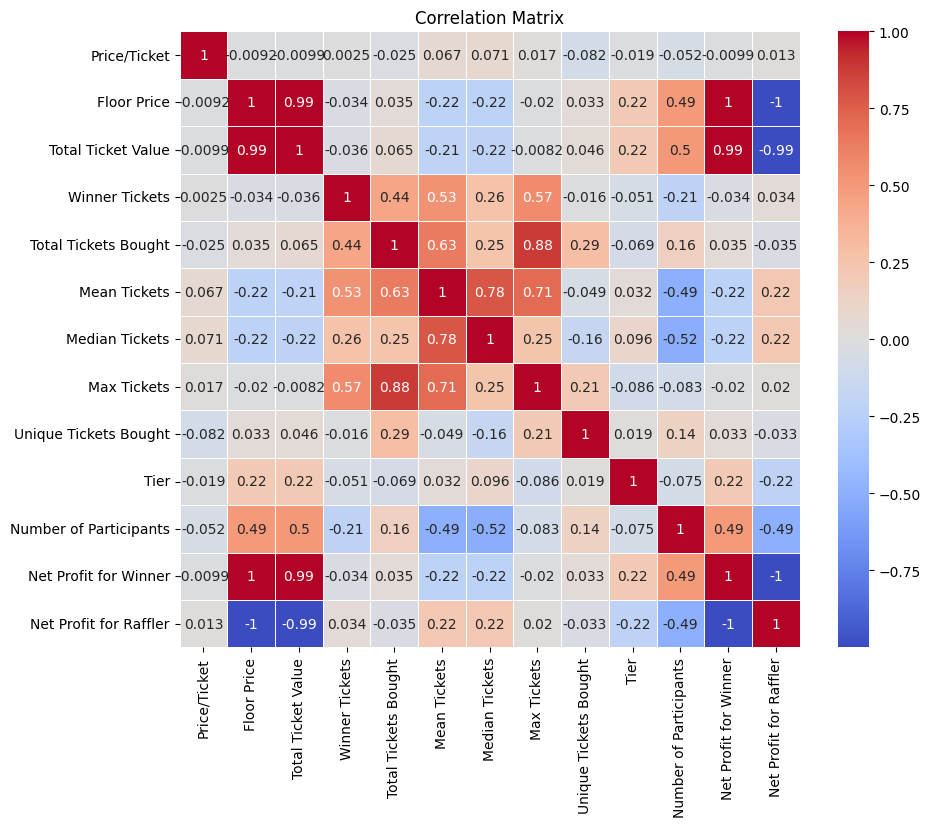

In [43]:
# Visualize the correlation matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [16]:
#!pip install plotly

In [49]:
import plotly.graph_objects as go
# Subset the data to include only NFT listings from Famous Fox Federation
dff = df[df['Title'].str.contains('Fox')]

# Reset index for the subset DataFrame
dff = dff.reset_index(drop=True)

# Create the stacked bar chart
fig = go.Figure()

# Add Winner Tickets
fig.add_trace(go.Bar(
    x=dff.index,
    y=dff['Winner Tickets'],
    name='Winner Tickets',
    hoverinfo='y',
    text=dff['Winner Tickets'],
    textposition='auto'
))

# Add Total Tickets Bought on top of Winner Tickets
fig.add_trace(go.Bar(
    x=dff.index,
    y=dff['Total Tickets Bought'] - dff['Winner Tickets'],
    name='Total Tickets Bought',
    hoverinfo='y',
    text=dff['Total Tickets Bought'],
    textposition='auto'
))

# Update layout for better appearance and readability
fig.update_layout(
    title='Stacked Bar Chart for Winner Tickets and Total Tickets Bought (Famous Fox Federation)',
    xaxis_title='Listing Index',
    yaxis_title='Number of Tickets',
    barmode='stack',
    width=800,  # Increase the width of the plot
    height=400
)

# Show the plot
fig.show()

In [54]:
import pandas as pd

# Assuming the DataFrame df is already defined and contains the necessary data

# Filter the DataFrame for the brand 'Taiyo Pilots'
taiyo_pilots_df = df[df['Title'].str.contains('Frogana')]

# Calculate the mean number of winner tickets
mean_winner_tickets = taiyo_pilots_df['Winner Tickets'].mean()

# Calculate the maximum number of winner tickets
max_winner_tickets = taiyo_pilots_df['Winner Tickets'].max()

# Calculate the minimum number of winner tickets
min_winner_tickets = taiyo_pilots_df['Winner Tickets'].min()

# Calculate the mode number of winner tickets
mode_winner_tickets = taiyo_pilots_df['Winner Tickets'].mode()

# Calculate the third quartile (75th percentile) number of winner tickets
third_quartile_winner_tickets = taiyo_pilots_df['Winner Tickets'].quantile(0.75)

print(f"Mean number of winner tickets for 'Taiyo Pilots': {mean_winner_tickets}")
print(f"Max number of winner tickets for 'Taiyo Pilots': {max_winner_tickets}")
print(f"Min number of winner tickets for 'Taiyo Pilots': {min_winner_tickets}")
print(f"Mode number of winner tickets for 'Taiyo Pilots': {mode_winner_tickets.tolist()}")
print(f"Third quartile (75th percentile) number of winner tickets for 'Taiyo Pilots': {third_quartile_winner_tickets}")


Mean number of winner tickets for 'Taiyo Pilots': 9.115384615384615
Max number of winner tickets for 'Taiyo Pilots': 20.0
Min number of winner tickets for 'Taiyo Pilots': 1.0
Mode number of winner tickets for 'Taiyo Pilots': [10.0]
Third quartile (75th percentile) number of winner tickets for 'Taiyo Pilots': 15.0


In [55]:
import pandas as pd

# Assuming the DataFrame df is already defined and contains the necessary data

# Filter the DataFrame for the brand 'Transdimensional Fox Federation'
the_heist_df = df[df['Title'].str.contains('Frogana')] 

# Initialize a list to store the expanded rows
expanded_rows = []

# Iterate over each row in the filtered DataFrame
for index, row in the_heist_df.iterrows():
    winner_tickets = row['Winner Tickets']
    ticket_frequency = eval(row['Ticket Frequency'])  # Assuming the column is a string representation of a dictionary
    
    tickets_bought = ticket_frequency['Tickets bought']
    frequencies = ticket_frequency['Frequency']
    
    # Expand the rows according to the frequencies
    for ticket, freq in zip(tickets_bought, frequencies):
        for _ in range(freq):
            expanded_rows.append({
                'Winner Tickets': winner_tickets, 
                'Tickets Bought': ticket, 
                'Number of Participants': winner_tickets
            })

# Create a new DataFrame from the expanded rows
expanded_df = pd.DataFrame(expanded_rows)

# Print the entire expanded DataFrame
print(expanded_df.to_string(index=False))

 Winner Tickets  Tickets Bought  Number of Participants
            5.0              14                     5.0
            5.0               7                     5.0
            5.0               6                     5.0
            5.0               5                     5.0
            5.0               4                     5.0
            5.0               3                     5.0
            5.0               1                     5.0
            5.0               1                     5.0
            5.0               1                     5.0
            5.0               1                     5.0
            5.0               1                     5.0
            5.0               1                     5.0
            5.0               1                     5.0
            5.0               1                     5.0
            5.0               1                     5.0
            5.0               1                     5.0
            5.0               1                 

In [181]:
#pip install scikit-learn

In [56]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error

# Assuming df is your DataFrame containing all the data

# Filter the DataFrame for rows where Title contains 'JTO'
historical_data = df[df['Title'].str.contains('Frogana')]

# Select the relevant columns
historical_data = historical_data[['Winner Tickets', 'Ticket Frequency', 'Tickets Remaining']]

# Extract features from the historical data
def extract_features(df):
    features = []
    target = []

    for index, row in df.iterrows():
        winner_tickets = row['Winner Tickets']
        ticket_frequency = eval(row['Ticket Frequency'])  # Convert string to dictionary
        tickets_remaining = row['Tickets Remaining']
        
        tickets_bought = ticket_frequency['Tickets bought']
        frequencies = ticket_frequency['Frequency']
        
        for ticket, freq in zip(tickets_bought, frequencies):
            features.append([ticket, freq, tickets_remaining])
            target.append(winner_tickets)

    return np.array(features), np.array(target)

# Prepare the data
X, y = extract_features(historical_data)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Define parameter grid for Lasso and Ridge
param_grid = {'alpha': np.logspace(-4, 4, 50)}

# Lasso Regression
lasso = Lasso()
lasso_cv = GridSearchCV(lasso, param_grid, cv=5)
lasso_cv.fit(X_train, y_train)
lasso_best = lasso_cv.best_estimator_
lasso_pred = lasso_best.predict(X_test)
lasso_rmse = mean_squared_error(y_test, lasso_pred, squared=False)

# Ridge Regression
ridge = Ridge()
ridge_cv = GridSearchCV(ridge, param_grid, cv=5)
ridge_cv.fit(X_train, y_train)
ridge_best = ridge_cv.best_estimator_
ridge_pred = ridge_best.predict(X_test)
ridge_rmse = mean_squared_error(y_test, ridge_pred, squared=False)

# Choose the best model
best_model = lasso_best if lasso_rmse < ridge_rmse else ridge_best

# Example input distribution
distribution = [(7,2),(6,1),(5,2),(4,2),(3,4),(1,7)]
remaining_tickets = 0   # single number indicating the total tickets you have left to buy

# Prepare the input features
input_features = []
for ticket, freq in distribution:
    input_features.append([ticket, freq, remaining_tickets])

# Convert input_features to numpy array
input_features = np.array(input_features)

# Make predictions
predicted_winner_tickets = best_model.predict(input_features).mean()

print(f"Predicted Winner Tickets: {predicted_winner_tickets}")

# Example: Comparing with closest matching historical distribution
def find_closest_match(distribution, historical_data):
    input_df = pd.DataFrame(distribution, columns=['Tickets Bought', 'Frequency'])
    input_df['Normalized Frequency'] = input_df['Frequency'] / input_df['Frequency'].sum()
    
    closest_match = None
    min_distance = float('inf')
    
    for index, row in historical_data.iterrows():
        historical_dist = eval(row['Ticket Frequency'])
        historical_dist_df = pd.DataFrame(historical_dist)
        historical_dist_df['Normalized Frequency'] = historical_dist_df['Frequency'] / historical_dist_df['Frequency'].sum()
        
        distance = np.linalg.norm(input_df['Normalized Frequency'] - historical_dist_df['Normalized Frequency'])
        
        if distance < min_distance:
            min_distance = distance
            closest_match = row
            
    return closest_match

closest_match = find_closest_match(distribution, historical_data)

print(f"Closest Matching Distribution: {closest_match}")

C:\Users\karan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



Predicted Winner Tickets: 7.722906928173093
Closest Matching Distribution: Winner Tickets                                                    10.0
Ticket Frequency     {'Tickets bought': [15, 10, 3, 2, 1, 1], 'Freq...
Tickets Remaining                                                   18
Name: 421, dtype: object


C:\Users\karan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



## Merging and preprocessing

In [44]:
import pandas as pd

In [45]:
#pip install xlrd

In [46]:
df1 = pd.read_csv('Cleaned-week1.csv')
df2 = pd.read_csv('Cleaned-week2.csv')
df3 = pd.read_csv('Cleaned-week3.csv')
df4 = pd.read_csv('Cleaned-week4.csv')

In [47]:
# Add 'Week' column to each dataframe
df1['Week'] = 1
df2['Week'] = 2
df3['Week'] = 3
df4['Week'] = 4
# Concatenate dataframes
dff = pd.concat([df1, df2, df3, df4], ignore_index=True)

dff.head()

,Unnamed: 0,Brand,Title,Seller,Tickets Remaining,Tier,Price/Ticket,Time,Link,Floor Price,Total Ticket Value,Winner,Winner Tickets,Ticket Frequency,Total Tickets,Number of Participants,Net Profit for Winner,Net Profit for Raffler,Week
0,0,Y00ts,y00t #10490,@ClarkOliiver,0,5,3.911460e-06,0:0:9:23,https://rafffle.famousfoxes.com/raffle/6T4szNZ...,6.35,6.95,4sUs...sHsz,17.0,"{'Tickets bought': [17, 13, 5, 3, 2, 2, 1, 1, ...",50,14.0,6.349934,-6.349804,1
1,1,Verified Token,769937 WEN,@DelanteFulton,0,2,7.006860e-07,0:0:15:57,https://rafffle.famousfoxes.com/raffle/8X67reQ...,0.96,1.24,@bhekimkhombo,10.0,"{'Tickets bought': [10, 10, 10, 7, 3, 3, 3, 3,...",50,9.0,0.959993,-0.959965,1
2,2,Frogana,Frogana #3420,@ScozziAxie,11,4,4.868220e-07,0:0:16:47,https://rafffle.famousfoxes.com/raffle/2x64MY1...,0.67,0.87,@Bladz01_SOL,10.0,"{'Tickets bought': [14, 10, 8, 2, 2, 1, 1, 1],...",50,8.0,0.669995,-0.669976,1
3,3,Verified Token,450 JUP,@Bladz01_SOL,0,5,2.110500e-06,0:0:21:11,https://rafffle.famousfoxes.com/raffle/GEDRCxG...,2.97,3.75,4sUs...sHsz,15.0,"{'Tickets bought': [15, 10, 10, 6, 3, 3, 1, 1,...",50,9.0,2.969968,-2.969894,1
4,4,Frogana,Frogana #210,@mjbreese613,0,5,5.346600e-07,0:0:26:23,https://rafffle.famousfoxes.com/raffle/6QWSsJT...,0.67,0.95,@Keik0000,3.0,"{'Tickets bought': [20, 10, 8, 7, 3, 1, 1], 'F...",50,7.0,0.669998,-0.669973,1


In [48]:
dff.isnull().sum()

Unnamed: 0                  0
Brand                       0
Title                       0
Seller                      0
Tickets Remaining           0
Tier                        0
Price/Ticket                0
Time                        0
Link                        0
Floor Price                 0
Total Ticket Value          0
Winner                      0
Winner Tickets              0
Ticket Frequency            0
Total Tickets               0
Number of Participants    629
Net Profit for Winner     629
Net Profit for Raffler    629
Week                        0
dtype: int64

In [49]:
dff = dff.dropna()

In [50]:
dff['Net Profit for Raffler'] = dff['Floor Price'] - dff['Total Ticket Value']
dff['Net Profit for Winner'] = dff['Floor Price'] - dff['Winner Tickets']*dff['Price/Ticket'] 

In [51]:
dff.to_csv('merged-4.csv')

In [52]:
# Strip the brand names for entries with "Verified Token" and replace them with specific tokens mentioned
def clean_brand_name(title):
    tokens = ["BONK", "JUP", "PYTH", "WEN", "WIF", "RAY", "JTO", "W", "TNSR"]
    for token in tokens:
        if token in title:
            return token
    return title

# Apply the cleaning function to the 'Brand' column where applicable
dff.loc[dff['Brand'] == 'Verified Token', 'Brand'] = dff[dff['Brand'] == 'Verified Token']['Title'].apply(clean_brand_name)

# Check the modified 'Brand' column to ensure 'Verified Token' has been replaced
dff['Brand'].value_counts()

Brand
JUP                                453
Transdimensional Fox Federation    308
Y00ts                              197
BONK                               141
WIF                                120
                                  ... 
The Bastards                         1
ABC                                  1
Toonies                              1
POPHEADZ                             1
Blockasset Legends                   1
Name: count, Length: 61, dtype: int64

In [53]:
len(dff)

2140

In [54]:
dff = dff.drop(columns ='Unnamed: 0', axis=1)

## Feature Selection

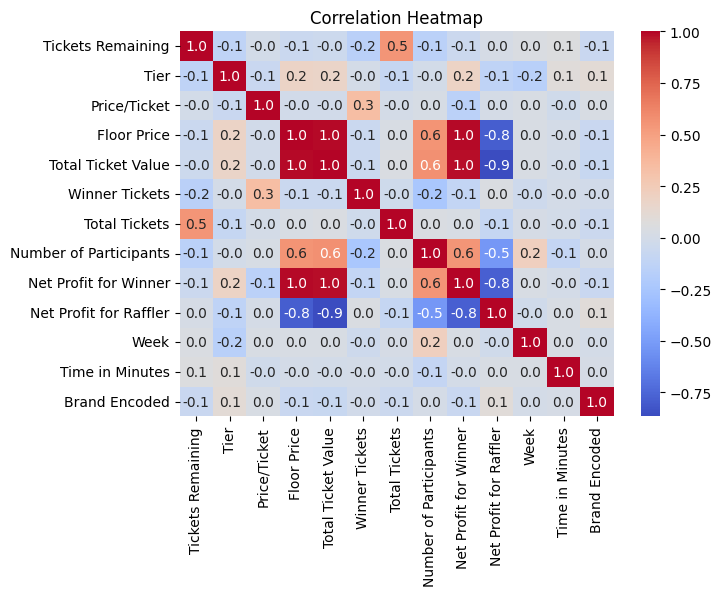

In [55]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Convert 'Time' and label encode 'Brand'
dff['Time in Minutes'] = dff['Time'].apply(lambda x: sum(int(a) * 60 ** i for i, a in enumerate(reversed(x.split(':')))) / 60)
label_encoder = LabelEncoder()
dff['Brand Encoded'] = label_encoder.fit_transform(dff['Brand'])
dff['Brand Encoded'] = dff['Brand Encoded'].astype('int64')

# Select numeric columns for correlation matrix
numeric_columns = dff.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = dff[numeric_columns].corr()

# Plotting the heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(correlation_matrix, annot=True, fmt=".1f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

### Skew correction

In [56]:
#!pip install statsmodels

In [57]:
numeric_columns

Index(['Tickets Remaining', 'Tier', 'Price/Ticket', 'Floor Price',
       'Total Ticket Value', 'Winner Tickets', 'Total Tickets',
       'Number of Participants', 'Net Profit for Winner',
       'Net Profit for Raffler', 'Week', 'Time in Minutes', 'Brand Encoded'],
      dtype='object')

In [58]:
dffx = dff[['Brand', 'Tickets Remaining', 'Price/Ticket', 'Floor Price', 'Total Ticket Value', 'Winner Tickets', 'Number of Participants', 'Net Profit for Winner','Brand Encoded', 'Time in Minutes','Week', 'Tier', 'Ticket Frequency']]
dffx = dff = pd.get_dummies(dffx, columns=['Week', 'Tier'], drop_first=True, prefix={'Week': 'Week', 'Tier': 'Tier'})
dffx.head()

,Brand,Tickets Remaining,Price/Ticket,Floor Price,Total Ticket Value,Winner Tickets,Number of Participants,Net Profit for Winner,Brand Encoded,Time in Minutes,Ticket Frequency,Week_3,Week_4,Tier_2,Tier_3,Tier_4,Tier_5
0,Y00ts,0,3.911460e-06,6.35,6.95,17.0,14.0,6.349934,59,9.383333,"{'Tickets bought': [17, 13, 5, 3, 2, 2, 1, 1, ...",False,False,False,False,False,True
1,WEN,0,7.006860e-07,0.96,1.24,10.0,9.0,0.959993,57,15.950000,"{'Tickets bought': [10, 10, 10, 7, 3, 3, 3, 3,...",False,False,True,False,False,False
2,Frogana,11,4.868220e-07,0.67,0.87,10.0,8.0,0.669995,21,16.783333,"{'Tickets bought': [14, 10, 8, 2, 2, 1, 1, 1],...",False,False,False,False,True,False
3,JUP,0,2.110500e-06,2.97,3.75,15.0,9.0,2.969968,24,21.183333,"{'Tickets bought': [15, 10, 10, 6, 3, 3, 1, 1,...",False,False,False,False,False,True
4,Frogana,0,5.346600e-07,0.67,0.95,3.0,7.0,0.669998,21,26.383333,"{'Tickets bought': [20, 10, 8, 7, 3, 1, 1], 'F...",False,False,False,False,False,True


In [59]:
import pandas as pd
import json

# Define a function to extract ticket statistics from the 'Ticket Frequency' column
def extract_ticket_stats(ticket_freq_str):
    try:
        ticket_data = json.loads(ticket_freq_str.replace("'", '"'))
    except json.JSONDecodeError:
        return pd.Series([0, 0, 0], index=['Median Tickets', 'Max Tickets', 'Min Tickets'])
    
    tickets_bought = ticket_data.get('Tickets bought', [])
    
    if not tickets_bought:
        return pd.Series([0, 0, 0], index=['Median Tickets', 'Max Tickets', 'Min Tickets'])
    
    sorted_tickets = sorted(tickets_bought)
    median_tickets = sorted_tickets[len(tickets_bought) // 2]
    max_tickets = max(tickets_bought)
    min_tickets = min(tickets_bought)
    
    return pd.Series([median_tickets, max_tickets, min_tickets], index=['Median Tickets', 'Max Tickets', 'Min Tickets'])

# Apply the function to extract stats from 'Ticket Frequency'
ticket_stats = dffx['Ticket Frequency'].apply(extract_ticket_stats)

# Concatenate these new features to the original DataFrame
dffx = pd.concat([dffx, ticket_stats], axis=1)

# Add a 'Rank' column for 'Winner Tickets'
dffx['Rank'] = dffx['Winner Tickets'].rank(method='min', ascending=False)

# Convert the rank into integer type
dffx['Rank'] = dffx['Rank'].astype(int)

dffx.head()

,Brand,Tickets Remaining,Price/Ticket,Floor Price,Total Ticket Value,Winner Tickets,Number of Participants,Net Profit for Winner,Brand Encoded,Time in Minutes,...,Week_3,Week_4,Tier_2,Tier_3,Tier_4,Tier_5,Median Tickets,Max Tickets,Min Tickets,Rank
0,Y00ts,0,3.911460e-06,6.35,6.95,17.0,14.0,6.349934,59,9.383333,...,False,False,False,False,False,True,1,17,1,313
1,WEN,0,7.006860e-07,0.96,1.24,10.0,9.0,0.959993,57,15.950000,...,False,False,True,False,False,False,3,10,1,736
2,Frogana,11,4.868220e-07,0.67,0.87,10.0,8.0,0.669995,21,16.783333,...,False,False,False,False,True,False,2,14,1,736
3,JUP,0,2.110500e-06,2.97,3.75,15.0,9.0,2.969968,24,21.183333,...,False,False,False,False,False,True,3,15,1,364
4,Frogana,0,5.346600e-07,0.67,0.95,3.0,7.0,0.669998,21,26.383333,...,False,False,False,False,False,True,7,20,1,1687


In [60]:
import pandas as pd
import json

# Define a function to extract the rank of 'Winner Tickets' based on its first occurrence in the 'Tickets Bought' list
def extract_winner_ticket_rank(ticket_freq_str, winner_ticket_count):
    try:
        ticket_data = json.loads(ticket_freq_str.replace("'", '"'))
    except json.JSONDecodeError:
        return None  # Return None or a suitable default if JSON is not decodable
    
    tickets_bought = ticket_data.get('Tickets bought', [])
    
    # Find the first index where 'Winner Tickets' matches in 'Tickets Bought' list
    # Add 1 to convert zero-based index to one-based rank
    try:
        return tickets_bought.index(winner_ticket_count) + 1
    except ValueError:
        return None  # Return None if 'Winner Tickets' is not found in the list

# Apply the function to each row in the DataFrame
# Assuming 'Winner Tickets' is a column in the DataFrame 'df'
dffx['Rank'] = dffx.apply(lambda row: extract_winner_ticket_rank(row['Ticket Frequency'], row['Winner Tickets']), axis=1)
dffx.head()

,Brand,Tickets Remaining,Price/Ticket,Floor Price,Total Ticket Value,Winner Tickets,Number of Participants,Net Profit for Winner,Brand Encoded,Time in Minutes,...,Week_3,Week_4,Tier_2,Tier_3,Tier_4,Tier_5,Median Tickets,Max Tickets,Min Tickets,Rank
0,Y00ts,0,3.911460e-06,6.35,6.95,17.0,14.0,6.349934,59,9.383333,...,False,False,False,False,False,True,1,17,1,1
1,WEN,0,7.006860e-07,0.96,1.24,10.0,9.0,0.959993,57,15.950000,...,False,False,True,False,False,False,3,10,1,1
2,Frogana,11,4.868220e-07,0.67,0.87,10.0,8.0,0.669995,21,16.783333,...,False,False,False,False,True,False,2,14,1,2
3,JUP,0,2.110500e-06,2.97,3.75,15.0,9.0,2.969968,24,21.183333,...,False,False,False,False,False,True,3,15,1,1
4,Frogana,0,5.346600e-07,0.67,0.95,3.0,7.0,0.669998,21,26.383333,...,False,False,False,False,False,True,7,20,1,5


In [63]:
x = dffx.drop(columns=['Ticket Frequency','Brand'], axis=1)

In [64]:
x.skew()

Tickets Remaining          5.747904
Price/Ticket              32.618020
Floor Price                4.920043
Total Ticket Value         4.993527
Winner Tickets             1.982572
Number of Participants     2.667076
Net Profit for Winner      4.664308
Brand Encoded             -0.227025
Time in Minutes           -0.015790
Week_3                     0.699435
Week_4                     1.281563
Tier_2                     1.926294
Tier_3                     2.209334
Tier_4                     1.158393
Tier_5                     0.351328
Median Tickets             2.036921
Max Tickets               19.836483
Min Tickets                9.076654
Rank                       1.535655
dtype: float64

In [65]:
neg_values = (x < 0).sum()
neg_values

Tickets Remaining         0
Price/Ticket              0
Floor Price               0
Total Ticket Value        0
Winner Tickets            0
Number of Participants    0
Net Profit for Winner     2
Brand Encoded             0
Time in Minutes           0
Week_3                    0
Week_4                    0
Tier_2                    0
Tier_3                    0
Tier_4                    0
Tier_5                    0
Median Tickets            0
Max Tickets               0
Min Tickets               0
Rank                      0
dtype: int64

#### Data skew transformations

In [66]:
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler

# Initialize a PowerTransformer with Yeo-Johnson
pt = PowerTransformer(method='yeo-johnson')

# Columns to transform: Adjusting only those that make sense
columns_to_transform = ['Tickets Remaining', 'Price/Ticket', 'Floor Price', 
                        'Total Ticket Value', 'Number of Participants', 
                        'Net Profit for Winner', 'Max Tickets', 'Min Tickets']

# Apply Yeo-Johnson transformation selectively
dft = x.copy()  # Create a copy to avoid modifying the original dataframe
dft[columns_to_transform] = pt.fit_transform(dft[columns_to_transform])

# Standardize the transformed data
scaler = StandardScaler()
dft[columns_to_transform] = scaler.fit_transform(dft[columns_to_transform])

In [67]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# For nominal variables: one-hot encoding
encoder = OneHotEncoder(drop='first')  # drop first to avoid multicollinearity

# Fit and transform the 'Brand Encoded' data
brand_encoded = encoder.fit_transform(dft[['Brand Encoded']].astype(str))  # Ensure the input is string if it isn't

# Generate DataFrame from the one-hot encoded array
# Use get_feature_names_out() to obtain column names
brand_encoded_df = pd.DataFrame(brand_encoded.toarray(), columns=encoder.get_feature_names_out())

# Concatenate the one-hot encoded DataFrame back to the original DataFrame, dropping the 'Brand Encoded' column
dft = pd.concat([dft.drop('Brand Encoded', axis=1), brand_encoded_df], axis=1)

In [68]:
len(dft.columns)

78

In [72]:
constant_columns = [col for col in dft.columns if dft[col].nunique() == 1]
dft = dft.drop(columns=constant_columns)

print(f"Removed constant columns: {constant_columns}")

Removed constant columns: ['Brand Encoded_28', 'Brand Encoded_29', 'Brand Encoded_45', 'Brand Encoded_49', 'Brand Encoded_8']


### VIF

In [73]:
import numpy as np

In [74]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming 'dft' is your DataFrame
# First ensure that all the data is numerical and does not contain infinity or missing values
dft = dft.select_dtypes(include=[np.number]).dropna().replace([np.inf, -np.inf], np.nan).fillna(0)

# Calculating VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = dft.columns
vif_data["VIF"] = [variance_inflation_factor(dft.values, i) for i in range(dft.shape[1])]

# Print the VIF for each column
print(vif_data.sort_values(by="VIF", ascending=False))

               Feature        VIF
2          Floor Price  31.621024
3   Total Ticket Value  29.490448
28    Brand Encoded_24   6.874965
57    Brand Encoded_54   5.166769
62    Brand Encoded_59   3.583481
..                 ...        ...
53    Brand Encoded_50   1.017211
21    Brand Encoded_18   1.017158
19    Brand Encoded_16   1.016764
64    Brand Encoded_60   1.014885
52     Brand Encoded_5   1.013823

[67 rows x 2 columns]


In [75]:
dftr = dft.drop(columns=['Floor Price'])

dftx = dftr.drop(columns=['Winner Tickets'])

dftx = dftx.drop(columns=['Net Profit for Winner'])

# Calculating VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = dftx.columns
vif_data["VIF"] = [variance_inflation_factor(dftx.values, i) for i in range(dftx.shape[1])]

# Print the VIF for each column
print(vif_data.sort_values(by="VIF", ascending=False))

                   Feature       VIF
3   Number of Participants  3.211075
25        Brand Encoded_24  2.881774
54        Brand Encoded_54  2.362427
5           Median Tickets  2.291248
59        Brand Encoded_59  1.926655
..                     ...       ...
18        Brand Encoded_18  1.008338
34        Brand Encoded_34  1.008149
23        Brand Encoded_22  1.006146
16        Brand Encoded_16  1.005143
49         Brand Encoded_5  1.003199

[64 rows x 2 columns]


In [39]:
dv = dftr[['Winner Tickets']]

## Model Development

In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

# Assuming dftx is your DataFrame of independent variables and dv contains the dependent variable 'Winner Tickets'
X = dftx
y = dv['Winner Tickets']

# Calculate the first and third quartiles
Q1 = y.quantile(0.25)
Q3 = y.quantile(0.75)
IQR = Q3 - Q1

# Define the upper bound as 75th percentile + 1.25 * IQR
upper_bound = Q3 + 1.25 * IQR

# Replace values above the upper bound with the upper bound value
capped_y = y.apply(lambda x: upper_bound if x > upper_bound else x)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, capped_y, test_size=0.2, random_state=42)

### Random Forest

In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, r2_score, mean_squared_error
from math import sqrt

# Define the model
rf = RandomForestRegressor(random_state=1)

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 300],  # Number of trees
    'max_depth': [5, 10, 20, 30],       # Maximum depth of trees
    'min_samples_split': [2, 4, 6, 8]   # Minimum number of samples required to split an internal node
}

# Define the scoring function
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring=make_scorer(rmse, greater_is_better=False))

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best estimator and its parameters
best_rf = grid_search.best_estimator_
print("Best parameters found: ", grid_search.best_params_)

# Making predictions using the best estimator
y_pred = best_rf.predict(X_test)

# Calculating RMSE and R2 for the best estimator
rmse = sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Adjusted R-squared
n = X_test.shape[0]
k = X_test.shape[1]
adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Printing the results
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")
print(f"Adjusted R-squared: {adjusted_r2}")

Best parameters found:  {'max_depth': 20, 'min_samples_split': 6, 'n_estimators': 100}
Root Mean Squared Error (RMSE): 1.535037100863837
R-squared (R2): 0.9291546747454691
Adjusted R-squared: 0.9146687296455012


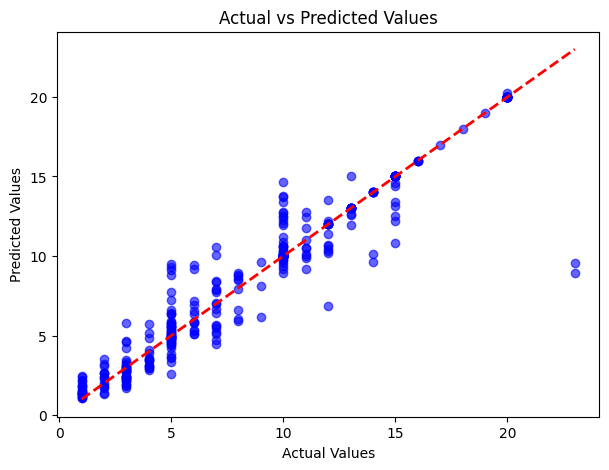

In [43]:
import matplotlib.pyplot as plt

# Scatter plot of real vs predicted values
plt.figure(figsize=(7, 5))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Line of perfect prediction
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

### Neural Network

In [80]:
#pip install tensorflow

In [83]:
#pip install keras_tuner

In [84]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import keras_tuner as kt
from sklearn.model_selection import train_test_split

# Define a function to build the model
def build_model(hp):
    model = Sequential()
    # Tune the number of layers and units in each layer
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32),
                        activation='relu'))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mse')
    return model

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=3,
    directory='my_dir',
    project_name='intro_to_kt')

# Search for the best hyperparameters
tuner.search(X_train, y_train, epochs=50, validation_split=0.2)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters
model = tuner.hypermodel.build(best_hps)
model.fit(X_train, y_train, epochs=100, validation_split=0.2)

# Make predictions
y_pred_nn = model.predict(X_test)

Trial 5 Complete [00h 00m 20s]
val_loss: 40.64694595336914

Best val_loss So Far: 40.64694595336914
Total elapsed time: 00h 01m 45s
Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3180.8501 - val_loss: 221.4555
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 113.4209 - val_loss: 85.2015
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 61.1652 - val_loss: 70.1876
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 65.2206 - val_loss: 85.9456
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 66.9129 - val_loss: 59.8364
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 67.3481 - val_loss: 98.7485
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 61.2706 - val_loss: 135.9282
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 73.5456 - val_loss: 75.7799
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 56.7497 - val_loss: 62.4089
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 51.1597 - val_loss: 

Epoch 67/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 278.8132 - val_loss: 64.2998
Epoch 68/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33.0264 - val_loss: 365.7963
Epoch 69/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 285.9428 - val_loss: 480.2264
Epoch 70/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 132.3084 - val_loss: 29.2900
Epoch 71/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23.2016 - val_loss: 215.9398
Epoch 72/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 58.0637 - val_loss: 709.8950
Epoch 73/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 183.7687 - val_loss: 124.3658
Epoch 74/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 68.3949 - val_loss: 73.6496
Epoch 75/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 30.6855 - val_loss: 42.9291
Epoch 76/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 34.1271 - val_loss: 29.2866
Epoch 77/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 34.5326 - val_loss: 63.0434
Epoch 78/100
31/31 ━━━━

Neural Network RMSE: 5.602279528504517
Neural Network R-squared: 0.05636727414255582
